In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy
from scipy.sparse import csr_matrix
sns.set(font_scale=1.5)
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sklearn.linear_model as lm
import sklearn.tree as tree

In [3]:
curr_dir = os.getcwd()

# Section 1 Reading Data

In [4]:
data_dir = curr_dir+'/2010-0760_Data/Data/Raw_csv/'

In [5]:
def read_survey(data_dir):
    names = ['hhid', 'ppid', 'age', 'education', 'village native', 'caste',
        'subcaste', 'work', 'occupation', 'work for private or public',
        'work outside or not', 'SHG/saving group', 'Loan', 'Savings', 'Election Card', 'Ration Card', 'Ration Card Color']
    file_list = os.listdir(data_dir)
    file_list.sort()
    data = pd.DataFrame()
    for file in file_list:
        if 'survey' in file:
            df = pd.read_csv(data_dir+file,header=None,names=names)
            data = data.append(df,sort=False,ignore_index=True)
    return data

In [6]:
def read_village_info(data_dir):
    names = ['hhid', 'ppid', 'gender','age']
    file_list = os.listdir(data_dir)
    file_list.sort()
    data = pd.DataFrame()
    for file in file_list:
        if 'village' in file:
            df = pd.read_csv(data_dir+file,header=None,names=names)
            df['village'] = [file.replace('village','').replace('.csv','') for i in range((df.shape[0]))]
            data = data.append(df,sort=False,ignore_index=True)
    return data

In [7]:
survey_data = read_survey(data_dir)
survey_data['id'] = [str(survey_data.loc[i,'hhid'])+str(survey_data.loc[i,'ppid']) if len(str(survey_data.loc[i,'ppid']))>1 
                     else str(survey_data.loc[i,'hhid'])+'0'+str(survey_data.loc[i,'ppid']) 
                     for i in survey_data.index ]
survey_data.set_index('id',inplace=True)
village = read_village_info(data_dir)
village['id'] = [str(village.loc[i,'hhid'])+str(village.loc[i,'ppid']) if len(str(village.loc[i,'ppid']))>1 
                     else str(village.loc[i,'hhid'])+'0'+str(village.loc[i,'ppid']) 
                     for i in village.index ]
village.set_index(['id'],inplace=True)
village.drop(columns=['hhid','ppid','age'],inplace=True)
survey_data = survey_data.join(village,how='inner',rsuffix='_v')

In [8]:
survey_data.replace(to_replace=[-999.,-888.], value=np.nan, inplace=True)
survey_data['education'].replace(to_replace=[16], value=np.nan, inplace=True)
survey_data.replace({ col_name: 2.0 for col_name in ['village native','work','work outside or not','SHG/saving group','Loan','Savings','gender']},
                      0, inplace=True)
survey_data.replace({ col_name: 3.0 for col_name in ['Election Card','Ration Card']},
                      0, inplace=True)
survey_data.replace({ col_name: 16.0 for col_name in ['education']},
                      np.nan, inplace=True)
survey_data.head()

hhid  ppid  age  education  village native  caste  subcaste  work  \
id                                                                          
100201  1002     1   38        2.0               1    3.0       2.0   1.0   
100202  1002     2   27        2.0               0    3.0       2.0   0.0   
100601  1006     1   29        7.0               1    3.0       2.0   1.0   
100602  1006     2   24       10.0               0    3.0       2.0   1.0   
100701  1007     1   58       10.0               1    3.0       2.0   1.0   

        occupation  work for private or public  work outside or not  \
id                                                                    
100201        13.0                         2.0                  1.0   
100202         NaN                         NaN                  NaN   
100601         1.0                         2.0                  0.0   
100602        15.0                         2.0                  0.0   
100701         1.0                         2.0                  0.0   

        SHG/saving group  Loan  Savings  Election Card  Ration Card  \
id                                                                    
100201               0.0   0.0      0.0            1.0          1.0   
100202               0.0   0.0      0.0            1.0          1.0   
100601               0.0   0.0      0.0            1.0          1.0   
100602               1.0   0.0      1.0            1.0          0.0   
100701               0.0   1.0      0.0            1.0          1.0   

        Ration Card Color  gender village  
id                                         
100201                1.0       1       1  
100202                1.0       0       1  
100601                1.0       1       1  
100602                NaN       0       1  
100701                1.0       1       1

In [9]:
survey_data.shape

(16995, 19)

# Section 2 Exploratory Data Analysis

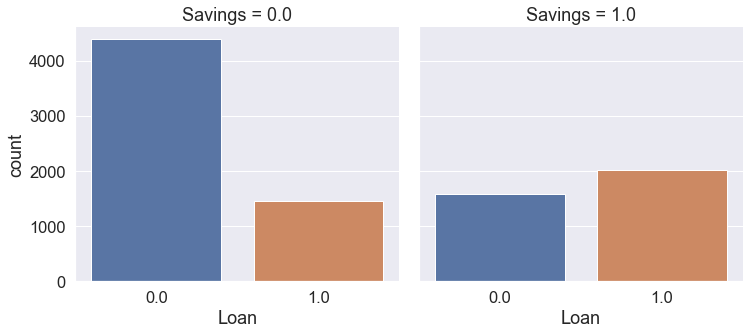

In [10]:
sns.catplot(x="Loan", col="Savings", col_wrap=4, data=survey_data, kind='count')

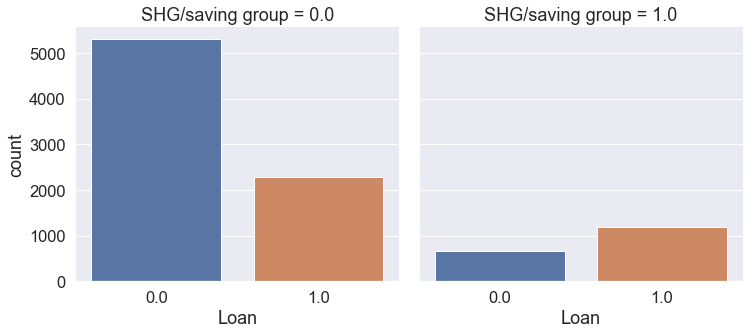

In [11]:
sns.catplot(x="Loan", col="SHG/saving group", col_wrap=4, data=survey_data, kind='count')

<AxesSubplot:xlabel='education', ylabel='age'>

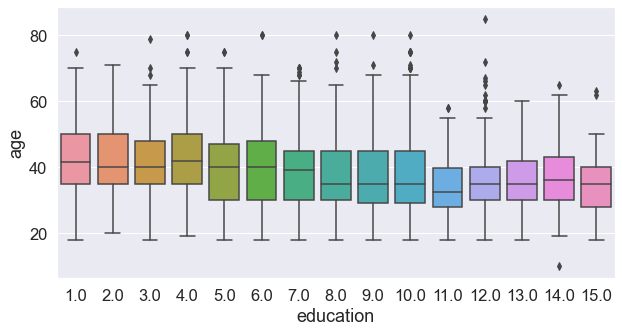

In [12]:
fig = plt.figure(figsize=(10,5))
sns.boxplot(x="education", y="age", data=survey_data.loc[survey_data['work']==1])

<AxesSubplot:xlabel='work for private or public', ylabel='education'>

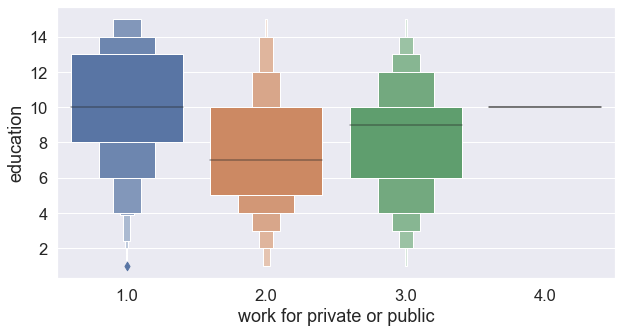

In [13]:
fig = plt.figure(figsize=(10,5))
sns.boxenplot(x="work for private or public", y="education", data=survey_data)

<Figure size 720x360 with 0 Axes>

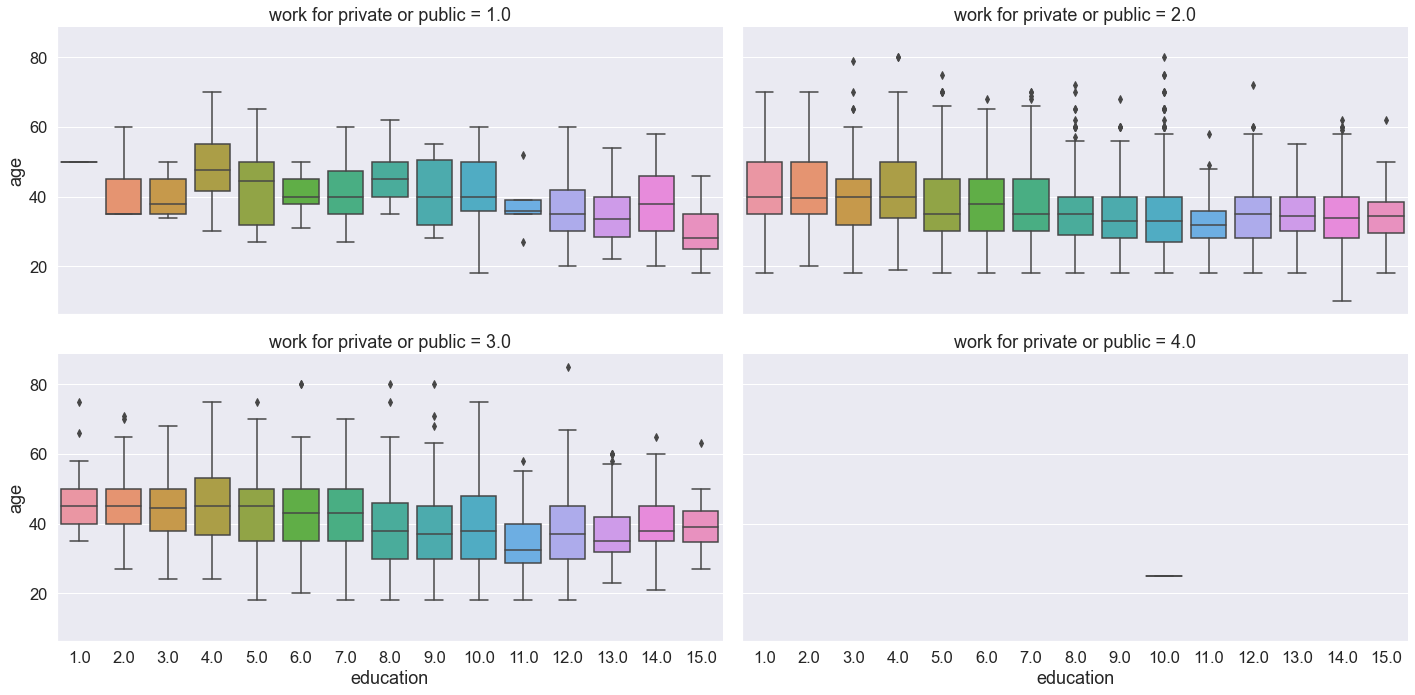

In [14]:
fig = plt.figure(figsize=(10,5))
sns.catplot(x="education", y="age",col='work for private or public', col_wrap=2, data=survey_data, kind='box',aspect=2)

<Figure size 720x360 with 0 Axes>

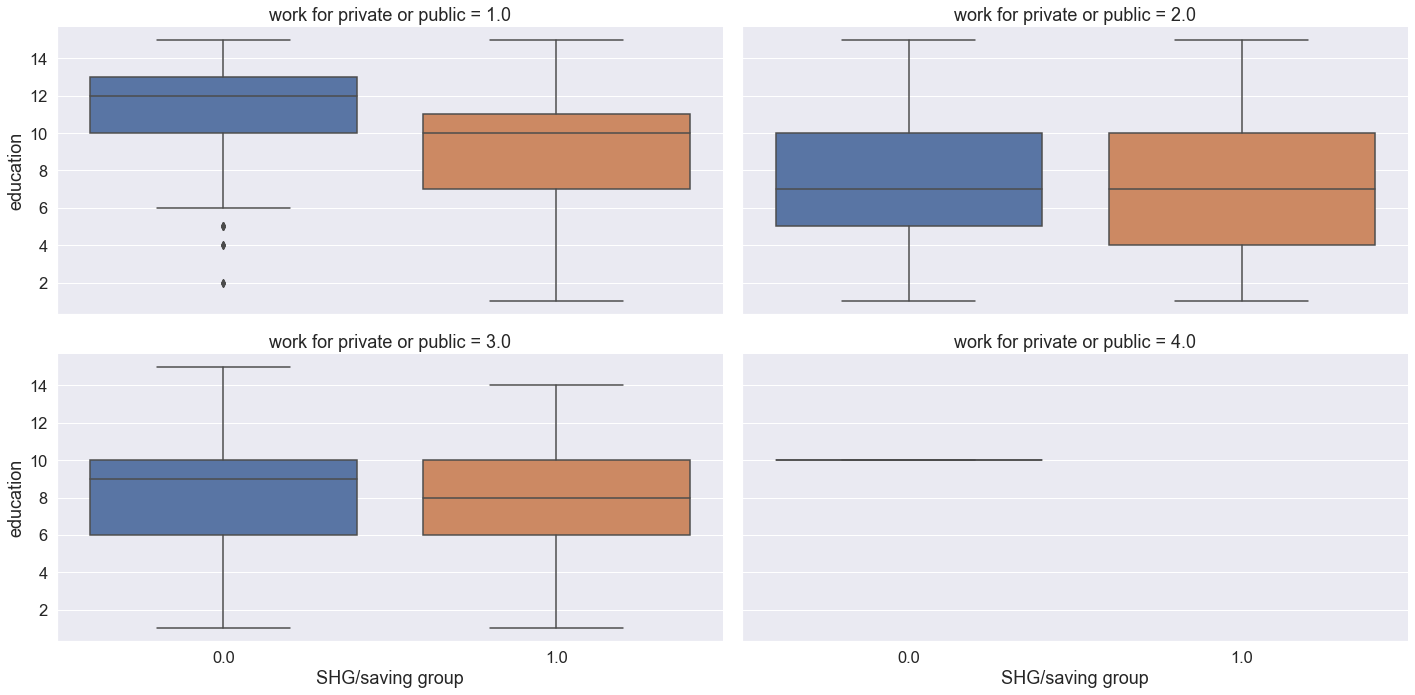

In [15]:
fig = plt.figure(figsize=(10,5))
sns.catplot(x="SHG/saving group", y="education",col='work for private or public', col_wrap=2, data=survey_data, kind='box',aspect=2)

<Figure size 720x360 with 0 Axes>

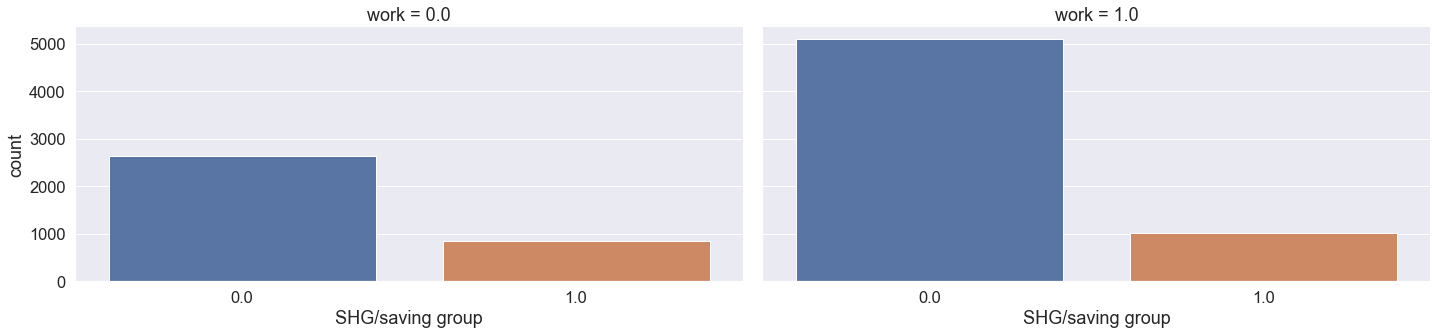

In [16]:
fig = plt.figure(figsize=(10,5))
sns.catplot(x="SHG/saving group", col="work", col_wrap=2, data=survey_data, kind='count',aspect=2)

<Figure size 720x360 with 0 Axes>

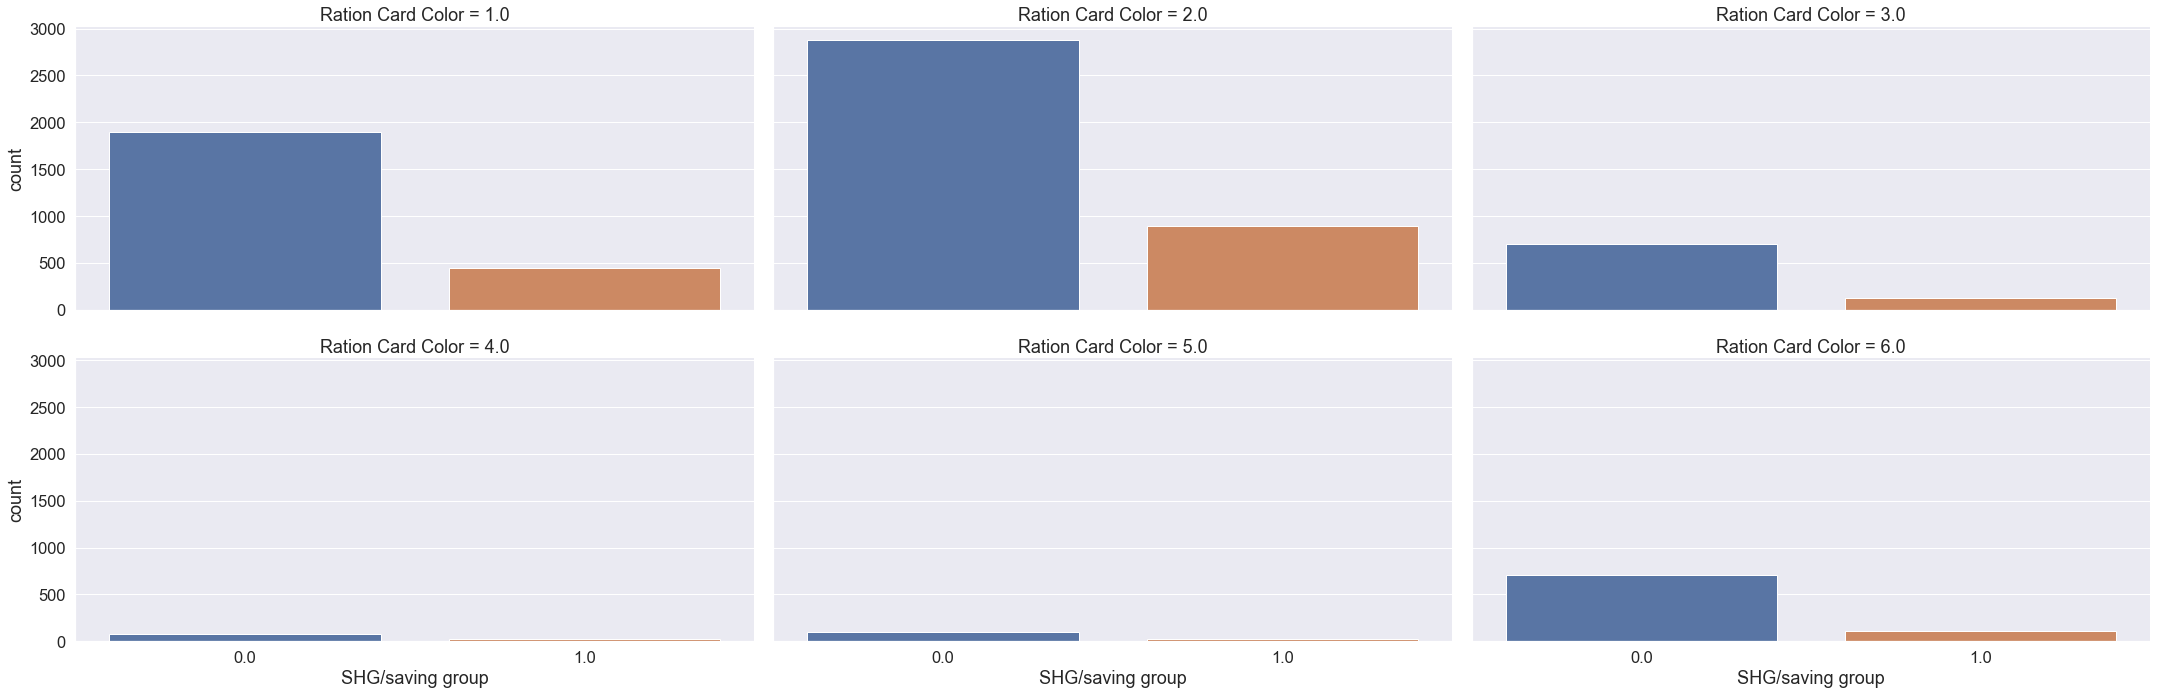

In [17]:
fig = plt.figure(figsize=(10,5))
sns.catplot(x="SHG/saving group", col="Ration Card Color", col_wrap=3, data=survey_data, kind='count',aspect=2)

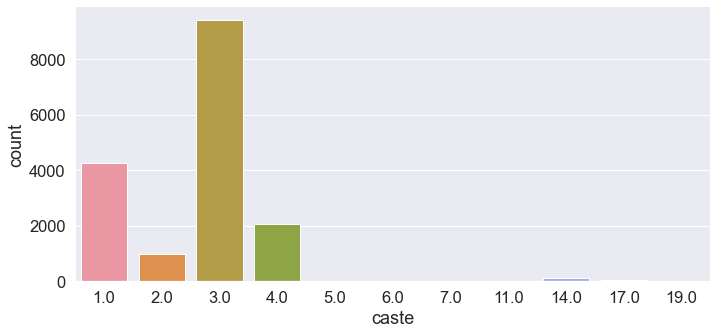

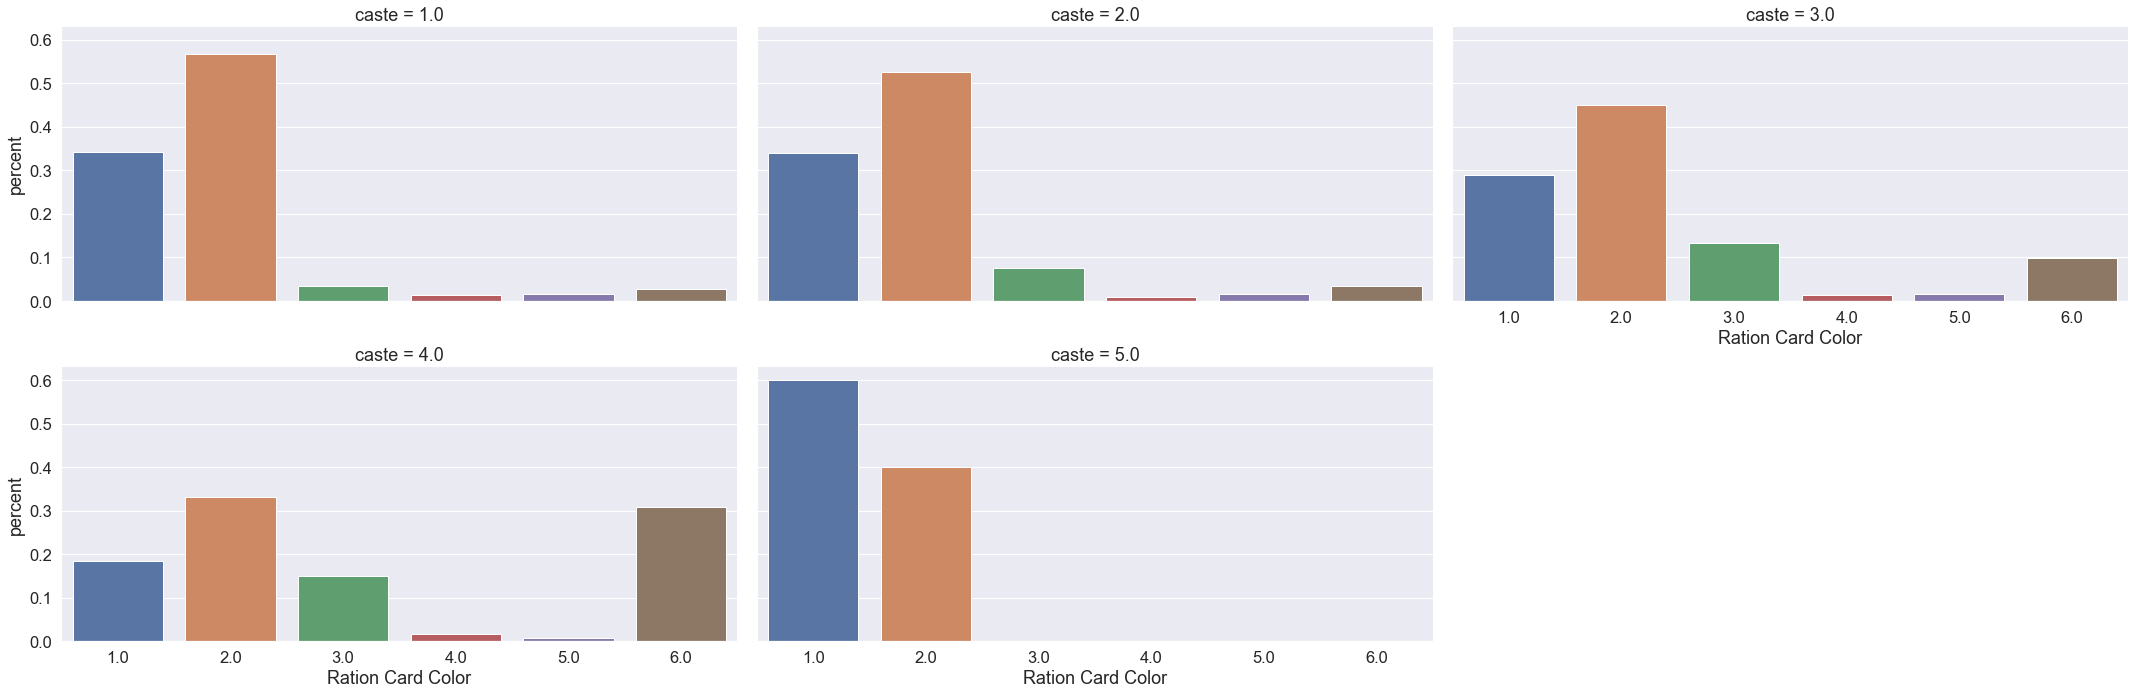

In [18]:
sns.catplot(x="caste", data=survey_data, kind='count',aspect=2)
survey_data_1 = survey_data.groupby('caste')["Ration Card Color"].value_counts(normalize=True)
survey_data_1 = survey_data_1.rename('percent').reset_index()
sns.catplot(x="Ration Card Color", y='percent', col='caste',col_wrap=3,data=survey_data_1, kind='bar',aspect=2)

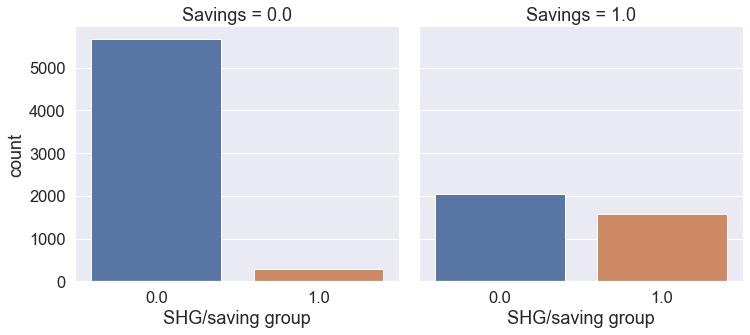

In [19]:
sns.catplot(x="SHG/saving group", col="Savings", col_wrap=4, data=survey_data, kind='count')

# Section 3 Estimating ATE (ignoring the network)

In [20]:
survey_data_dummified = pd.get_dummies(survey_data, 
                                       dummy_na=False, columns=['village native', 'caste',
                                                                'work', 'occupation', 
                                                                'work for private or public',
                                                                'work outside or not', 
                                                                'SHG/saving group', 'Loan', 
                                                                'Savings', 'Election Card',
                                                                'Ration Card Color','village','gender'], sparse=False, drop_first=True, dtype=None)
survey_data_dummified = survey_data_dummified.drop(columns=['ppid','subcaste','caste_6.0','caste_7.0','caste_11.0',
                                                            'caste_14.0','caste_17.0', 'caste_19.0','work for private or public_4.0',
                                                            'Ration Card','Election Card_2.0','Ration Card Color_4.0',
                                                           'Ration Card Color_5.0','Ration Card Color_6.0'])

## Section 3.1 Logistic Regression (Effect of SHG on Loans)

In [21]:
Y = survey_data_dummified['Loan_1.0']
X = survey_data_dummified.drop(columns=['Loan_1.0']).fillna(0)
logistic_model = lm.RidgeClassifierCV().fit(X,Y)
X.shape

(16995, 137)

In [22]:
coef = pd.Series(logistic_model.coef_[0],index=X.columns)
# coef.plot(kind='barh',figsize=(8,40))
ATE = coef['SHG/saving group_1.0']
print('ATE = %.3f'%(ATE))

ATE = 0.499


# Section 4 Network Analysis

In [23]:
import networkx as nx
from pyvis.network import Network
net = Network()

## Section 4.1 Reading Network Data

In [25]:
network_of_interest = ['nonrel','visitcome','visitgo','templecompany','rel','lendmoney','keroricecome']
file_list = os.listdir(curr_dir+'/2010-0760_Data/Data/Raw_csv/')
networks = { s:pd.DataFrame() for s in network_of_interest}
for file in file_list:
    if np.max([(ni in file) for ni in network_of_interest])>0:
        df = pd.read_csv(data_dir+file,header=None,names=['ppid']+['n%d'%(i) for i in range(8)])
        df = df.astype(str)
        df = df.rename(columns={'ppid':'id'}).set_index('id')
        net_type = network_of_interest[np.argmax([(ni in file) for ni in network_of_interest])]
        v_idx = file.replace('.csv','').replace(net_type,'')
        df['village'] = [v_idx for i in range(df.shape[0])]
#         print((net_type,v_idx))
        data = networks[net_type]
        data = data.append(df,sort=False)
        networks[net_type] = data

In [26]:
social = pd.DataFrame(np.zeros((survey_data.shape[0],survey_data.shape[0])),index=survey_data.index,columns=survey_data.index)
for net_type in network_of_interest:
    df = networks[net_type].copy(deep=True)
    df = df.drop(columns=['village'])
    for idx in df.index:
        adj_list = set(df.loc[idx])
        for n in adj_list:
            try:
                if n!='0':
                    social.loc[idx,n] = social.loc[idx,n]+1
                    social.loc[n,idx] = social.loc[n,idx]+1
            except:
                continue

In [27]:
G = nx.from_pandas_adjacency(social>0)

In [28]:
social_b = (social>0).astype(int)
S = csr_matrix(social_b)
S2 = S*S
S_tri = S2+S
triangle_count = (S_tri>1).sum(axis=1)

<AxesSubplot:>

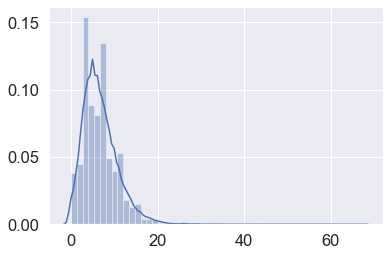

In [29]:
degree = S.sum(axis=1)
sns.distplot(degree)

## Section 4.2 Causal Relational Learning (CARL)

In [30]:
df = survey_data_dummified.copy(deep=True)

### Section 4.2.1 Unit Table Generation

In [31]:
def summarize(df):
    df2 = df.drop(columns=['occupation_%.1f'%(i) for i in range(1,46)]+['village_%d'%(i) for i in range(2,78)],errors='ignore').rename(columns={c:'neighbor_'+c for c in df.columns})
    sr = df2.mean(axis=0)
    return sr

In [32]:
data_w_neighbor_cov = pd.DataFrame()
idxs = set(df.index)
for idx in idxs:
    n_idxs = np.unique(list(networks['rel'].loc[idx])+list(networks['nonrel'].loc[idx])+list(networks['visitcome'].loc[idx])+list(networks['visitgo'].loc[idx]))
    n_idxs = set(np.delete(n_idxs, np.where(n_idxs == '0')))
    n_idxs = n_idxs.intersection(idxs)
    sr = summarize(df.loc[n_idxs]) #df.loc[n_idxs].max(axis=0).drop(['occupation_%.1f'%(i) for i in range(1,46)]+['village_%d'%(i) for i in range(2,78)],errors='ignore').rename(index={c:'neighbor_'+c for c in df.columns})
    df2 = pd.DataFrame(df.loc[idx].append(sr),columns=[idx]).T
    data_w_neighbor_cov = data_w_neighbor_cov.append(df2)

In [33]:
data_w_neighbor_cov.to_csv('data_w_summarized_neighbor_cov.csv')

### Section 4.2.2 Descriptive Analytics

In [34]:
caste_corr = np.zeros((5,5))
df_caste = data_w_neighbor_cov[[(s) for s in data_w_neighbor_cov.columns if 'caste' in s]]
for idx in df_caste.index[:]:
    caste = np.argmax(df_caste.loc[idx,['caste_%.1f'%(i) for i in range(2,6)]].to_numpy())
    neighbor_caste = df_caste.loc[idx,['neighbor_caste_%.1f'%(i) for i in range(2,6)]].to_numpy()
    if np.sum(df_caste.loc[idx,['caste_%.1f'%(i) for i in range(2,6)]]) > 0:
        caste_corr[caste+1,:] = caste_corr[caste+1,:] + np.array([1-np.nansum(neighbor_caste)]+list(np.nan_to_num(neighbor_caste)))
    else:
        caste_corr[0,:] = caste_corr[0,:] + np.array([1-np.nansum(neighbor_caste)]+list(np.nan_to_num(neighbor_caste)))

In [35]:
caste_corr = pd.DataFrame(caste_corr/caste_corr.sum(axis=1)[:,np.newaxis],
             index=['caste_%.1f'%(i) for i in range(1,6)],
             columns=['neighbor_caste_%.1f'%(i) for i in range(1,6)])

### 4.2.3 Adding Network Structure information to Unit Table

In [36]:
data_w_neighbor_cov['triangle'] = triangle_count
data_w_neighbor_cov['degree'] = degree

In [37]:
Y = data_w_neighbor_cov['Loan_1.0'].fillna(0)
T = data_w_neighbor_cov['SHG/saving group_1.0'].fillna(0)
X = data_w_neighbor_cov.drop(columns=['hhid','neighbor_hhid','Loan_1.0','SHG/saving group_1.0',
                                      'village_10','village_11','village_12','village_14','village_15','village_16',
                                      'village_17','village_18','village_19','village_2','village_20','village_21',
                                      'village_23','village_24','village_25','village_26','village_27','village_28',
                                      'village_29','village_3','village_30','village_31','village_32','village_33',
                                      'village_34', 'village_35','village_36','village_37','village_38','village_39',
                                      'village_4','village_40','village_41','village_42','village_43','village_44',
                                      'village_45','village_46','village_47','village_48','village_49','village_5',
                                      'village_50','village_51','village_52','village_53','village_54','village_55',
                                      'village_56','village_57','village_58','village_59','village_6','village_60',
                                      'village_61','village_62','village_63','village_64','village_65','village_66',
                                      'village_67','village_68','village_69','village_7','village_70','village_71',
                                      'village_72','village_73','village_74','village_75','village_76','village_77',
                                      'village_8','village_9','neighbor_Loan_1.0']).fillna(0)
X_wo_neighbors_outcome = data_w_neighbor_cov.drop(columns=['hhid','neighbor_hhid','Loan_1.0','SHG/saving group_1.0','neighbor_Loan_1.0']).fillna(0)

In [38]:
model_c = lm.LogisticRegressionCV().fit(X.loc[T==0.0],Y.loc[T==0.0])
model_t = lm.LogisticRegressionCV().fit(X.loc[T==1.0],Y.loc[T==1.0])

In [39]:
CDE = (model_t.predict_log_proba(X)[:,1] - model_c.predict_log_proba(X)[:,1])
df_CDE = pd.DataFrame(CDE,index=X.index,columns=['TE'])
print(np.mean(CDE))

2.2035332340507914


Text(0, 0.5, 'Estimated Probability Density of CDE')

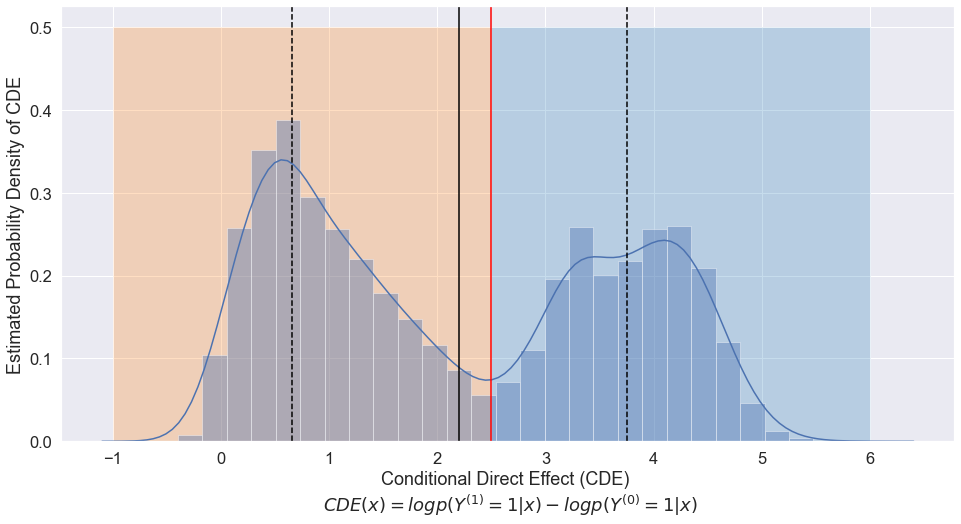

In [40]:
fig = plt.figure(figsize=(16,8))
sns.distplot(CDE)
plt.axvline(2.5,c='red')
plt.axvline(np.mean(CDE),c='black')
plt.axvline(np.mean(CDE)-np.std(CDE),ls='--',c='black')
plt.axvline(np.mean(CDE)+np.std(CDE),ls='--',c='black')
plt.fill_between(np.linspace(-1,2.5,50), 0, 0.5,facecolor='#ff7f0e', alpha=0.25)
plt.fill_between(np.linspace(2.5,6,50), 0, 0.5,facecolor='#1f77b4', alpha=0.25)
plt.xlabel('Conditional Direct Effect (CDE) \n $CDE(x) = logp(Y^{(1)}=1|x) - logp(Y^{(0)}=1|x)$')
plt.ylabel('Estimated Probability Density of CDE')

Text(0.5, 1.0, 'Who is Benefitted by participating in SHG/Saving Group?\n(Blue => Benefitted; Orange => Not Benefitted)')

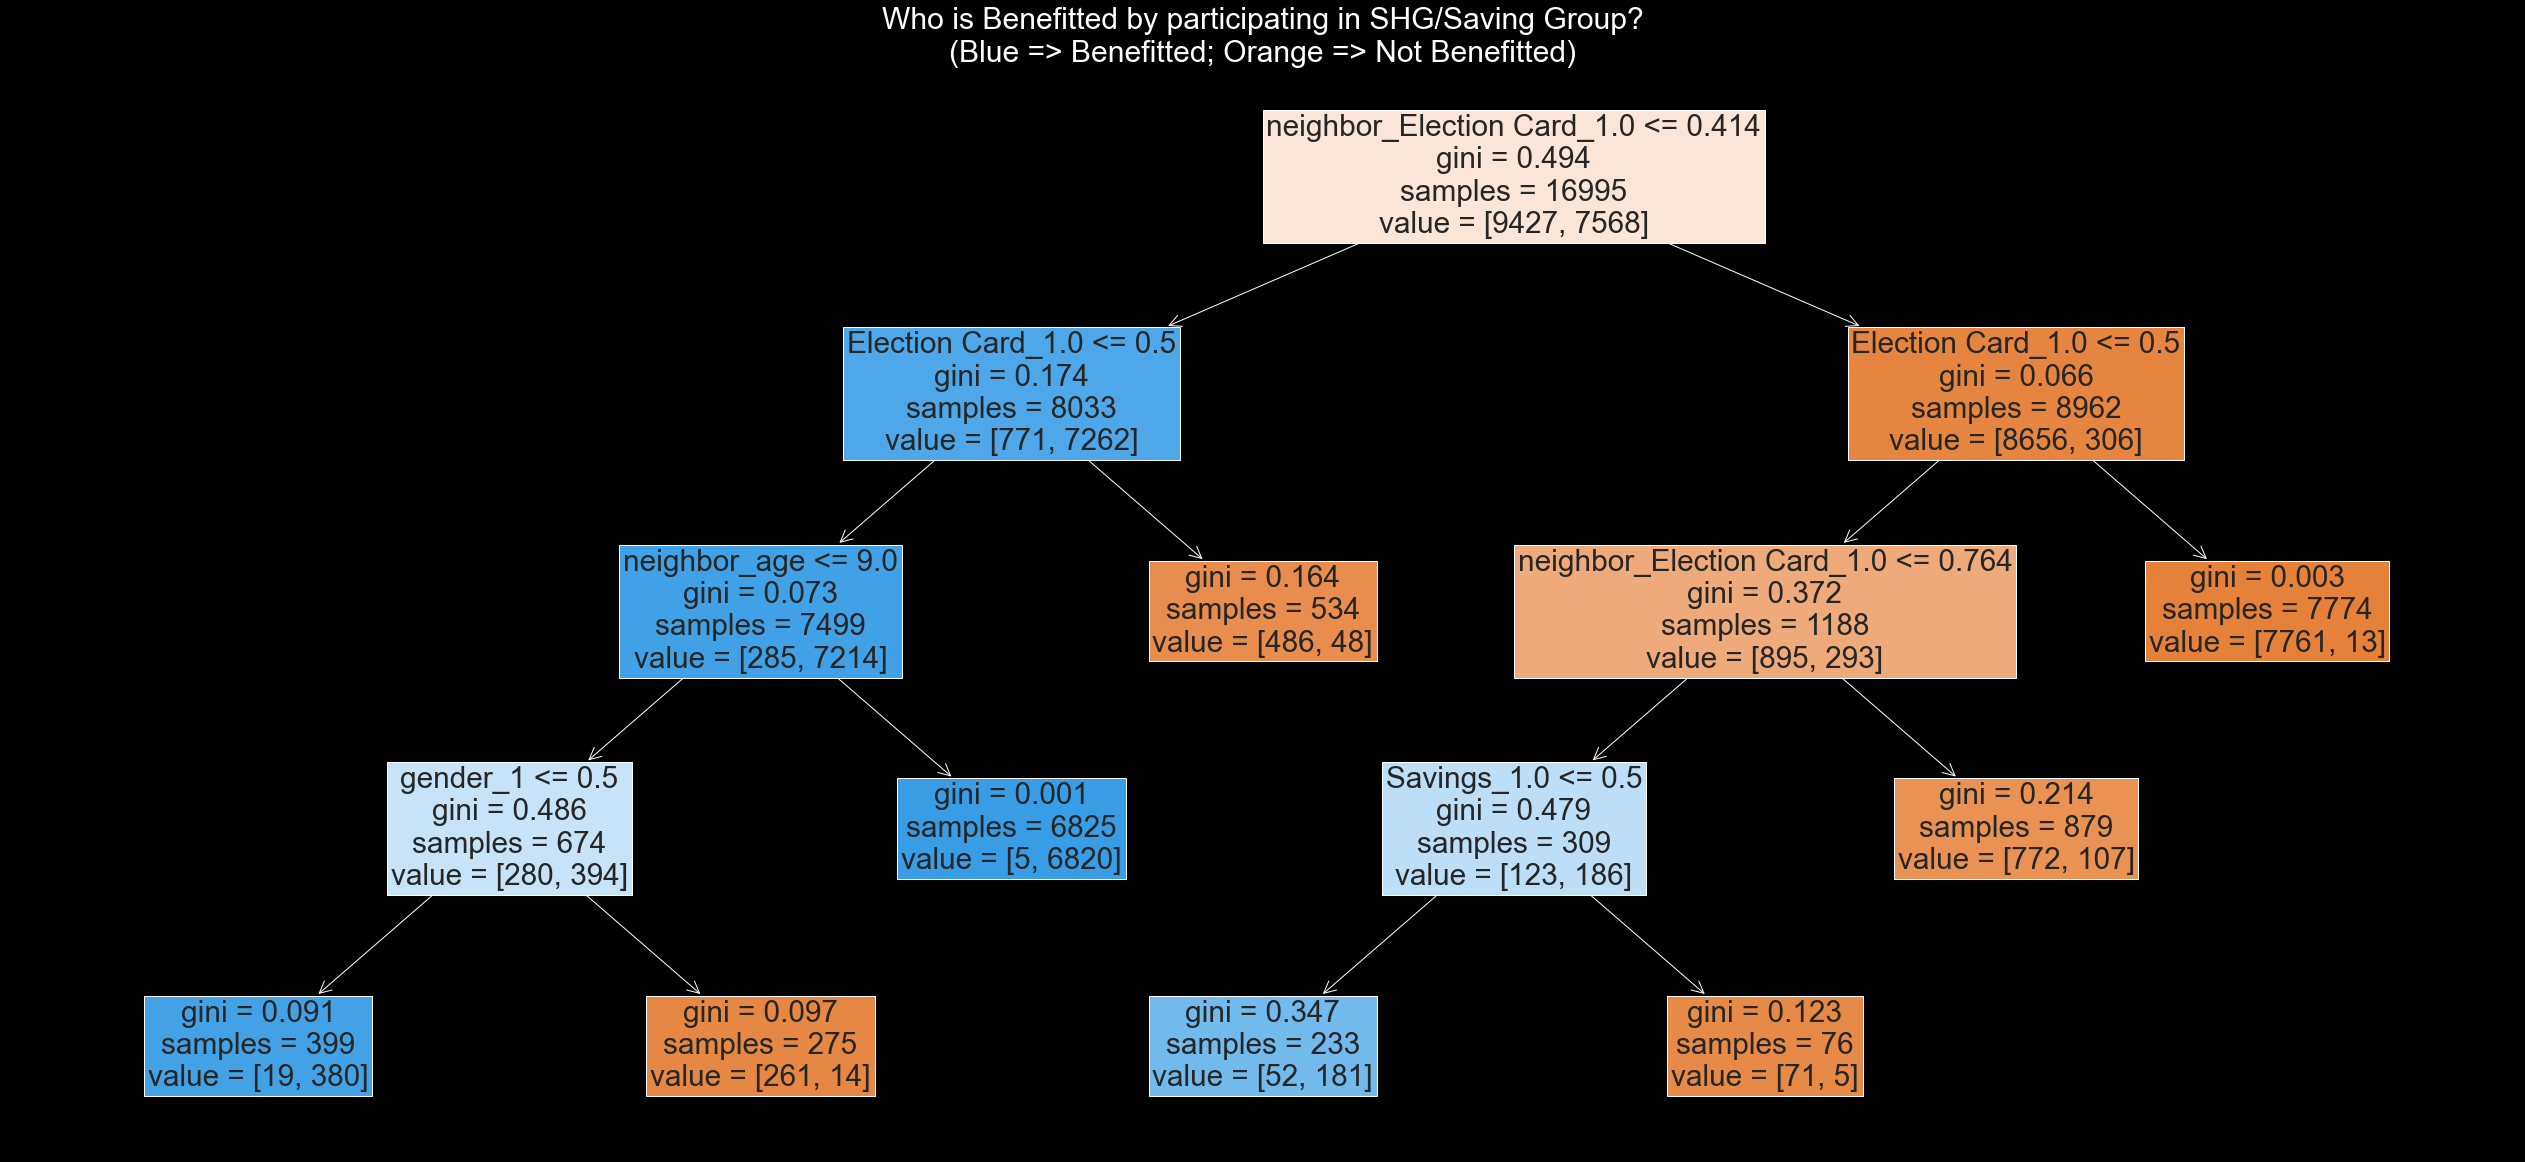

In [41]:
model_hetero = tree.DecisionTreeClassifier(max_leaf_nodes=8).fit(X,CDE>(2.5))
model_hetero.score(X,CDE>(2.5))
sns.set(font_scale=2.5)
fig = plt.figure(figsize=(45,20),facecolor='black')
tree.plot_tree(model_hetero,feature_names=X.columns,filled=True)
plt.title('Who is Benefitted by participating in SHG/Saving Group?\n(Blue => Benefitted; Orange => Not Benefitted)',color='white')

# Monte Carlo Computation for Fast-Approximate Search

In [43]:
idxs = data_w_neighbor_cov.dropna().index
sample_size = len(idxs)
sample_idxs = np.random.choice(idxs,sample_size,replace=False)
sample_data = data_w_neighbor_cov.loc[sample_idxs]
sample_data

hhid   age  education  village native_1  caste_2.0  caste_3.0  \
2603001  26030.0  52.0       10.0               1.0        0.0        1.0   
3413902  34139.0  28.0        4.0               0.0        0.0        1.0   
5003304  50033.0  22.0       12.0               0.0        0.0        0.0   
1501301  15013.0  30.0       14.0               0.0        0.0        1.0   
1811101  18111.0  45.0        5.0               1.0        0.0        0.0   
...          ...   ...        ...               ...        ...        ...   
7311802  73118.0  25.0       10.0               0.0        0.0        1.0   
6520104  65201.0  30.0       14.0               1.0        0.0        0.0   
4711301  47113.0  68.0        7.0               1.0        0.0        1.0   
603401    6034.0  50.0        9.0               0.0        0.0        1.0   
4817803  48178.0  40.0        7.0               1.0        0.0        1.0   

         caste_4.0  caste_5.0  work_1.0  occupation_1.0  ...  \
2603001        0.0        0.0       1.0             0.0  ...   
3413902        0.0        0.0       0.0             0.0  ...   
5003304        1.0        0.0       0.0             0.0  ...   
1501301        0.0        0.0       1.0             0.0  ...   
1811101        0.0        0.0       1.0             0.0  ...   
...            ...        ...       ...             ...  ...   
7311802        0.0        0.0       0.0             0.0  ...   
6520104        1.0        0.0       1.0             0.0  ...   
4711301        0.0        0.0       1.0             1.0  ...   
603401         0.0        0.0       1.0             0.0  ...   
4817803        0.0        0.0       1.0             1.0  ...   

         neighbor_work outside or not_1.0  neighbor_SHG/saving group_1.0  \
2603001                          0.500000                       0.000000   
3413902                          0.000000                       0.000000   
5003304                          0.000000                       0.333333   
1501301                          0.200000                       0.000000   
1811101                          0.333333                       0.000000   
...                                   ...                            ...   
7311802                          0.000000                       0.400000   
6520104                          0.333333                       0.333333   
4711301                          0.000000                       0.000000   
603401                           0.000000                       0.000000   
4817803                          0.400000                       0.000000   

         neighbor_Loan_1.0  neighbor_Savings_1.0  neighbor_Election Card_1.0  \
2603001                0.0              0.000000                         0.0   
3413902                0.0              0.000000                         0.0   
5003304                0.0              0.666667                         1.0   
1501301                0.0              0.000000                         0.0   
1811101                0.0              0.000000                         0.0   
...                    ...                   ...                         ...   
7311802                0.0              0.600000                         1.0   
6520104                0.0              0.666667                         1.0   
4711301                0.5              0.500000                         1.0   
603401                 0.0              0.000000                         0.0   
4817803                0.0              0.000000                         0.0   

         neighbor_Ration Card Color_2.0  neighbor_Ration Card Color_3.0  \
2603001                        0.000000                             0.0   
3413902                        0.000000                             0.0   
5003304                        0.333333                             0.0   
1501301                        0.000000                             0.0   
1811101                        0.000000                             0

In [44]:
Delta = [(nx.complete_graph(3),0),(nx.complete_graph(4),0),(nx.complete_graph(5),0),(nx.complete_graph(6),0),(nx.house_x_graph(),2)]
Delta_col = ['Clique-3','Clique-4','Clique-5','Clique-6','G-HouseX']

In [45]:
df_delta = get_delta_u(social_b,Delta,Delta_col,idxs=sample_idxs)
df_delta.mean(axis=0)

100%|██████████| 8994/8994 [02:23<00:00, 62.87it/s]


Clique-3    0.853458
Clique-4    0.421392
Clique-5    0.124305
Clique-6    0.022904
G-HouseX    0.368579
dtype: float64

In [46]:
df_delta.mean(axis=0)

Clique-3    0.853458
Clique-4    0.421392
Clique-5    0.124305
Clique-6    0.022904
G-HouseX    0.368579
dtype: float64

In [75]:
sample_w_netstruct = sample_data.join(df_delta,how='inner').drop(columns=['hhid'])
sample_w_netstruct.mean(axis=0)

age                 36.431955
education            8.127863
village native_1     0.628530
caste_2.0            0.043807
caste_3.0            0.598065
                      ...    
Clique-3             0.853458
Clique-4             0.421392
Clique-5             0.124305
Clique-6             0.022904
G-HouseX             0.368579
Length: 163, dtype: float64

In [48]:
Y = sample_w_netstruct['Loan_1.0'].fillna(0)
T = sample_w_netstruct['SHG/saving group_1.0'].fillna(0)
X = sample_w_netstruct.drop(columns=['neighbor_hhid','Loan_1.0','SHG/saving group_1.0',
                                      'village_10','village_11','village_12','village_14','village_15','village_16',
                                      'village_17','village_18','village_19','village_2','village_20','village_21',
                                      'village_23','village_24','village_25','village_26','village_27','village_28',
                                      'village_29','village_3','village_30','village_31','village_32','village_33',
                                      'village_34', 'village_35','village_36','village_37','village_38','village_39',
                                      'village_4','village_40','village_41','village_42','village_43','village_44',
                                      'village_45','village_46','village_47','village_48','village_49','village_5',
                                      'village_50','village_51','village_52','village_53','village_54','village_55',
                                      'village_56','village_57','village_58','village_59','village_6','village_60',
                                      'village_61','village_62','village_63','village_64','village_65','village_66',
                                      'village_67','village_68','village_69','village_7','village_70','village_71',
                                      'village_72','village_73','village_74','village_75','village_76','village_77',
                                      'village_8','village_9','neighbor_Loan_1.0']).fillna(0)

In [49]:
model_c = lm.LogisticRegressionCV().fit(X.loc[T==0.0],Y.loc[T==0.0])
model_t = lm.LogisticRegressionCV().fit(X.loc[T==1.0],Y.loc[T==1.0])

In [50]:
CDE = (model_t.predict_log_proba(X)[:,1] - model_c.predict_log_proba(X)[:,1])
df_CDE = pd.DataFrame(CDE,index=X.index,columns=['TE'])
print(np.mean(CDE))

2.293634543179229


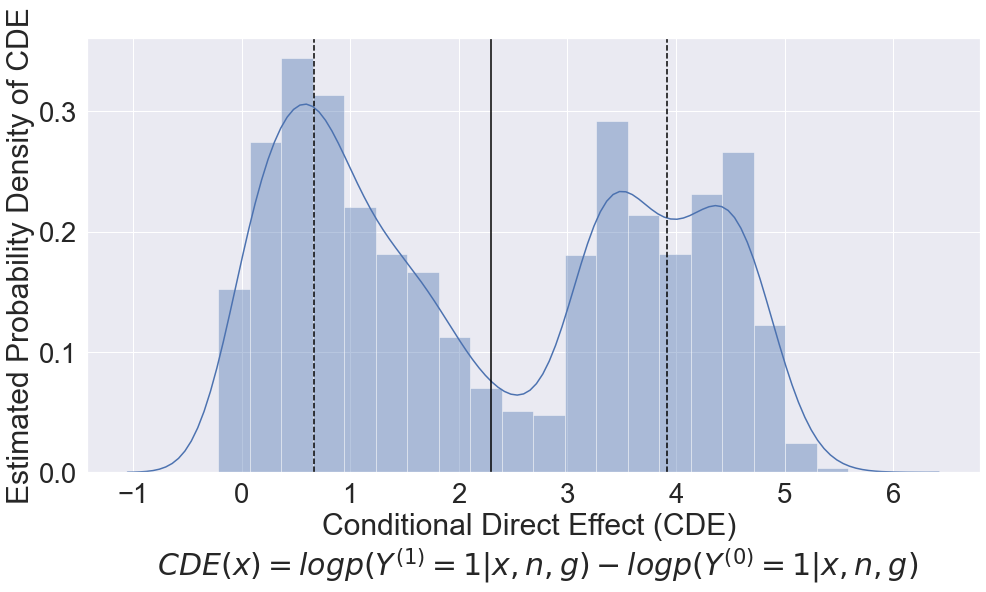

In [68]:
fig = plt.figure(figsize=(16,8))
sns.distplot(CDE)
# plt.axvline(2.5,c='red')
plt.axvline(np.mean(CDE),c='black')
plt.axvline(np.mean(CDE)-np.std(CDE),ls='--',c='black')
plt.axvline(np.mean(CDE)+np.std(CDE),ls='--',c='black')
# plt.fill_between(np.linspace(-1,2.5,50), 0, 0.5,facecolor='#ff7f0e', alpha=0.25)
# plt.fill_between(np.linspace(2.5,6,50), 0, 0.5,facecolor='#1f77b4', alpha=0.25)
plt.xlabel('Conditional Direct Effect (CDE) \n $CDE(x) = logp(Y^{(1)}=1|x,n,g) - logp(Y^{(0)}=1|x,n,g)$')
plt.ylabel('Estimated Probability Density of CDE')
plt.savefig('CDE_mf.png')

Text(0.5, 1.0, 'Who is Benefitted by participating in SHG/Saving Group?\n(Blue => Benefitted; Orange => Not Benefitted)')

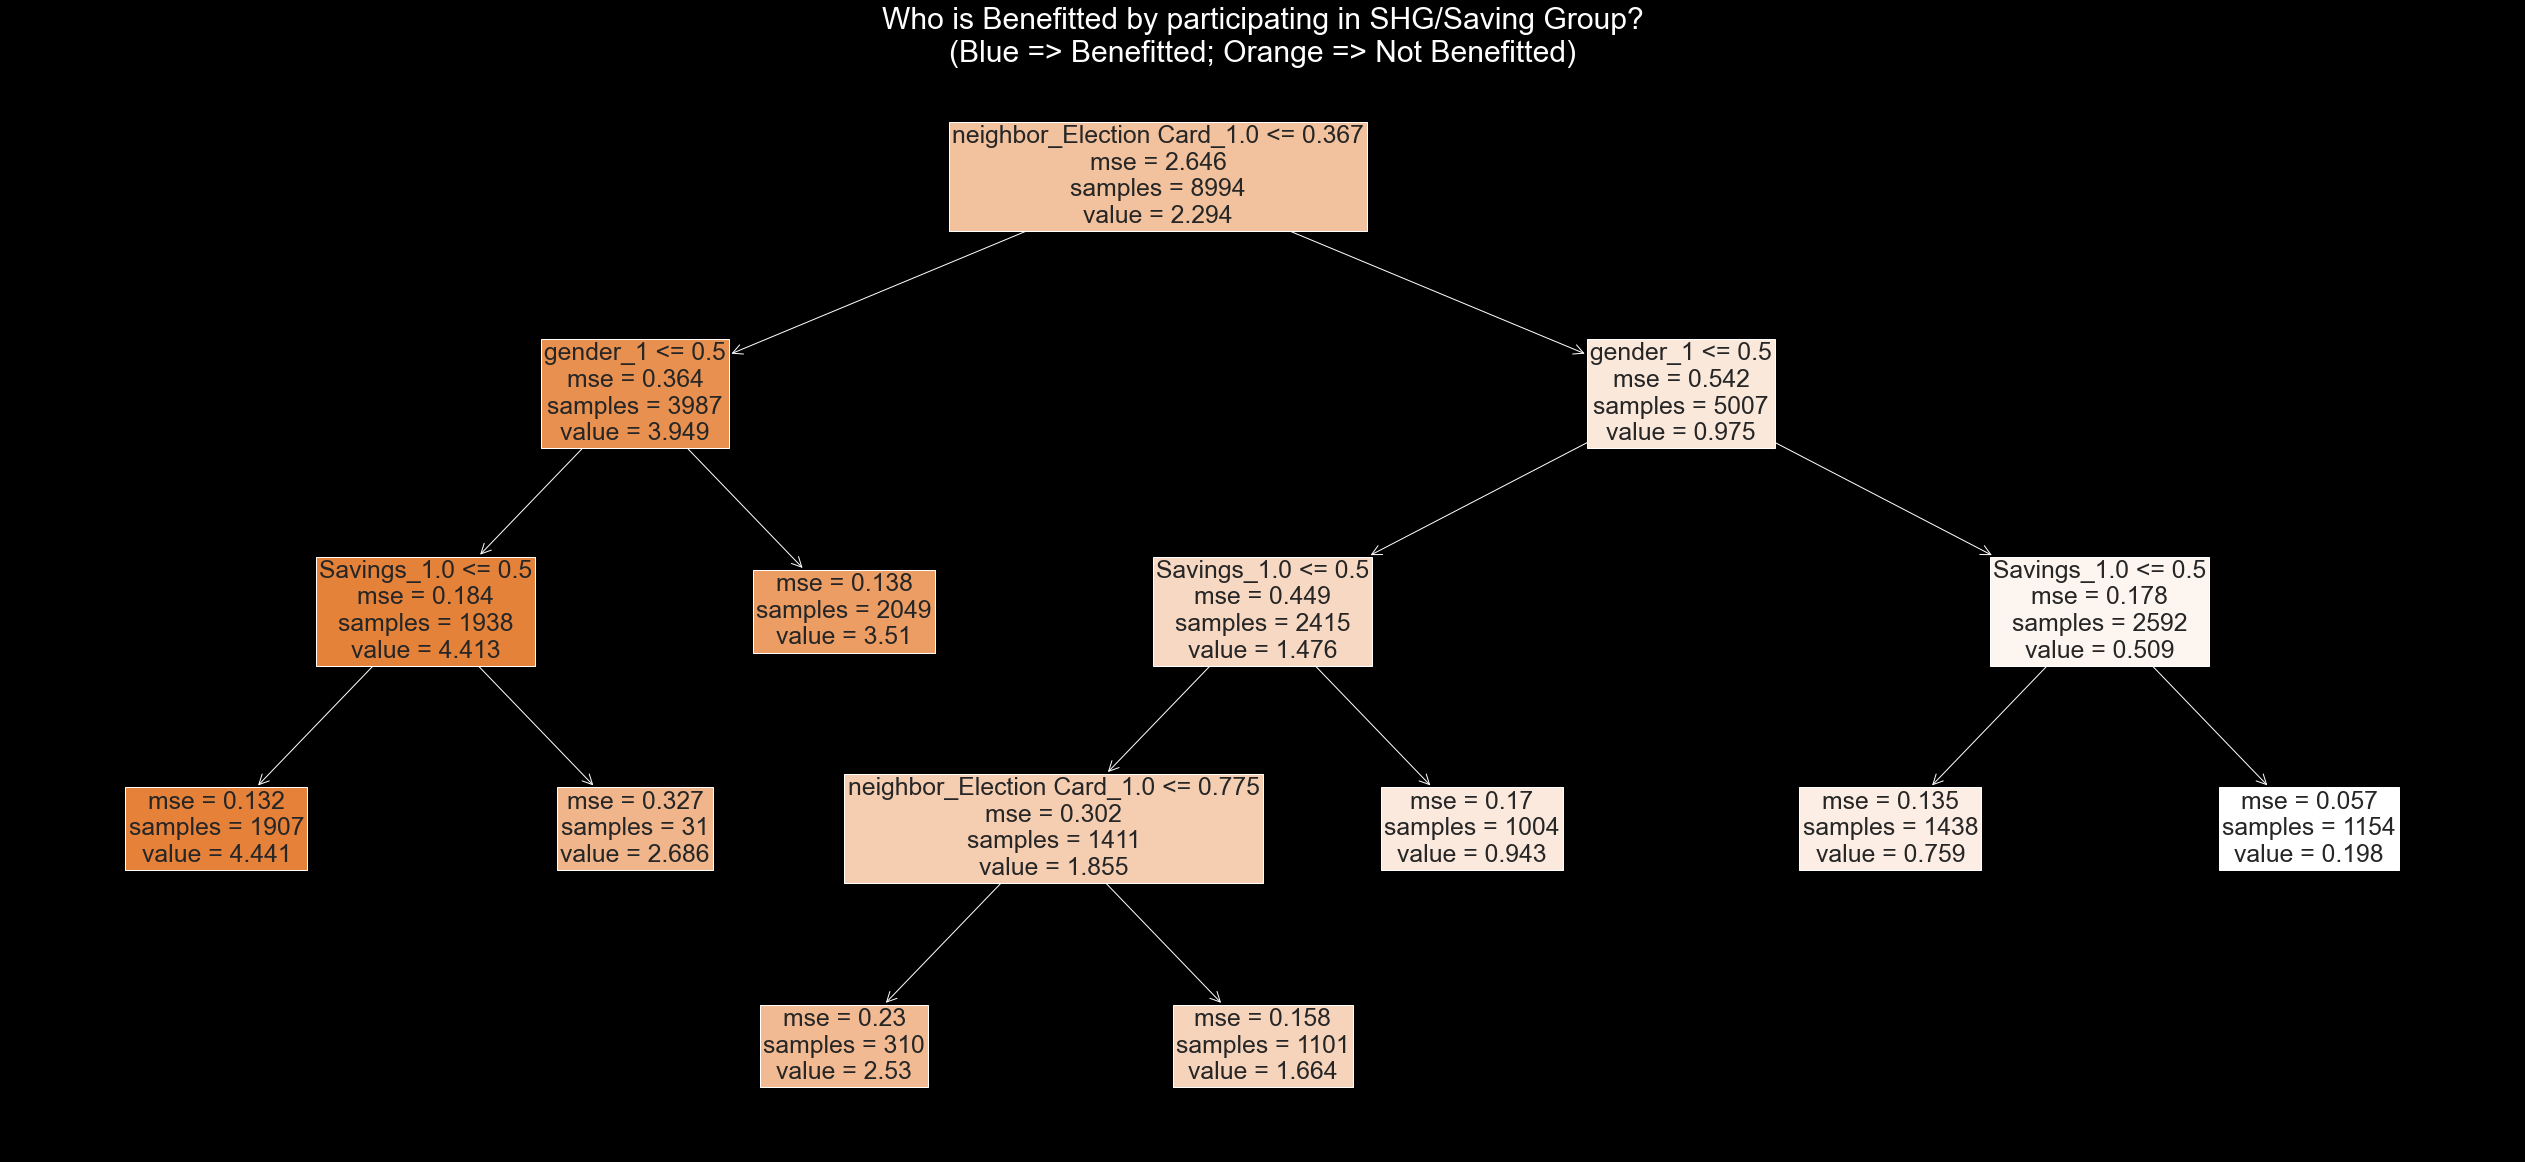

In [64]:
model_hetero = tree.DecisionTreeRegressor(max_leaf_nodes=8).fit(X,CDE)
model_hetero.score(X,CDE)
sns.set(font_scale=2.5)
fig = plt.figure(figsize=(45,20),facecolor='black')
tree.plot_tree(model_hetero,feature_names=X.columns,filled=True)
plt.title('Who is Benefitted by participating in SHG/Saving Group?\n(Blue => Benefitted; Orange => Not Benefitted)',color='white')

In [66]:
min(CDE)

-0.21472055323349915

<AxesSubplot:xlabel='neighbor_Election Card_1.0', ylabel='TE'>

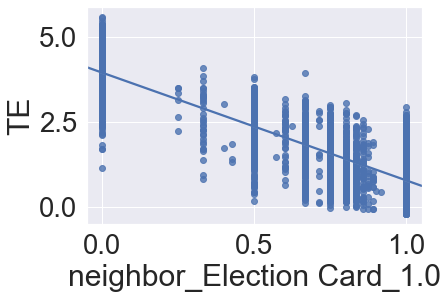

In [53]:
# sns.distplot(df_CDE.loc[X['Clique-7']==1]['TE'])
# sns.distplot(df_CDE.loc[X['Clique-6']==0]['TE'])
# sns.distplot(df_CDE.loc[X['Clique-6']==1]['TE'])
sns.regplot(X['neighbor_Election Card_1.0'],df_CDE['TE'])

0.9631015365160033


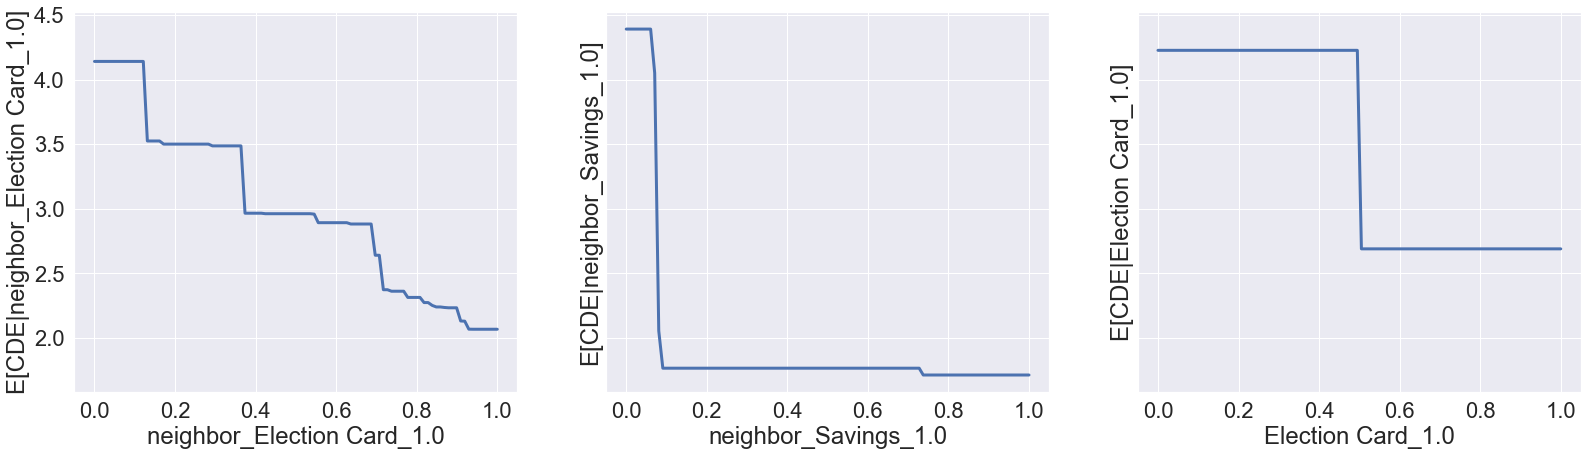

In [74]:
sns.set(font_scale=2)
from sklearn.model_selection import train_test_split
import sklearn.ensemble as ensemble
X_train, X_test, y_train, y_test = train_test_split( X, CDE, test_size=0.05, random_state=42)
additive_model = ensemble.AdaBoostRegressor(n_estimators=1000).fit(X_train,y_train)
# print(additive_model.estimator_weights_)
print(additive_model.score(X_test,y_test))
y_test_hat = additive_model.predict(X_test)
# print(confusion_matrix(y_test,y_test_hat))
estimators = additive_model.estimators_
# fig,ax = plt.subplots( ncols=4, nrows=( (len(estimators)-1)//4) + 1, figsize=(28,7*(( (len(estimators)-1)//4) + 1)),facecolor='k')
estimator_f = {}
for i in range(len(estimators)):
    estimator = estimators[i]
    idx = (np.argmax(estimator.feature_importances_))
    if idx not in estimator_f:
        estimator_f[idx] = []
    estimator_f[idx] = estimator_f[idx] + [estimator]
#     axi = ax[i//4,i%4]
#     tree.plot_tree(estimator,feature_names=list(X.columns),filled=True,ax=axi)
# fig.savefig('adaBoost_Estimators.png')

samples = 100
cols = list(X.columns)
fig,ax = plt.subplots(ncols=3, nrows=( (len(estimator_f.keys())-1)//3) + 1, figsize=(27,7*(( (len(estimator_f.keys())-1)//3) + 1)),sharex=False,sharey=True)
i = 0
# plt.title('Marginal Distributions')
for key in estimator_f.keys():
    x_range = np.min(X[cols[key]]),np.max(X[cols[key]])
    X1 = np.zeros((samples,len(cols)))
    X1[:,key] = np.linspace(x_range[0],x_range[1],num=100)
    est_k = estimator_f[key]
    y_hat = np.zeros((samples,))
    for estr in est_k:
        y_hat += estr.predict(X1)
    y_hat = y_hat/len(est_k)
    if ( (len(estimator_f.keys())-1)//3) > 0:
        axi = ax[i//3,i%3]
    else:
        axi = ax[i%3]
    axi.plot(X1[:,key],y_hat[:],linewidth=3)
    axi.set_xlabel(cols[key])
    axi.set_ylabel('E[CDE|%s]'%(cols[key]))
    i += 1
fig.savefig('adaBoost_f.png')

In [72]:
estimator_f.keys()

dict_keys([74, 73, 57])

# Contributions
1. How do we want to sell this paper? a. An Interpretable Approach for Detecting Heterogeneity in Relational Data

In [151]:
def summarize(df):
    df2 = df.rename(columns={c:'neighbor_'+c for c in df.columns})
    sr = df2.mean(axis=0)
    return sr

from tqdm import tqdm
def contains(G,H,j):
    ## is H contained in G?
    A = G
    GM = nx.algorithms.isomorphism.GraphMatcher(A,H)
    is_isomorphic = int(GM.subgraph_is_isomorphic())
    return is_isomorphic

#     if is_isomorphic:
#         GM_1 = nx.algorithms.isomorphism.ISMAGS(H,A)
#         iso_lst = list(GM_1.largest_common_subgraph())
#         for iso in iso_lst:
#             if (j in iso) and (len(iso)==len(H.nodes())):
# #                 print(iso[j])
#                 if (iso[j] == list(A.nodes())[0]):
#                     return 1
#     return 0

def get_first_order_egocentric_graph(G,i):
    Ai = G.loc[i]
#     print(np.where(Ai==1)[0])
    idx = [i]+list(Ai.loc[Ai>0].index)
    A_ego = G.loc[idx][idx]
    return A_ego

def get_x_u(V,X):
    return V[X]

def get_delta_u(G,Delta,Delta_col,idxs):
    df = pd.DataFrame()
    for i in (idxs):
        Gi = get_first_order_egocentric_graph(G,i)
        Gi1 = Gi.to_numpy()
        u_i = pd.DataFrame(np.array([ contains(nx.from_numpy_array(Gi1),delta[0],delta[1]) for delta in Delta]).reshape(1,-1),index=[i],columns=Delta_col)
        df = df.append(u_i)
    return df

def get_u(G,V,X,Delta,Delta_col):
    df_delta = get_delta_u(G,Delta,Delta_col)
    df_x = get_x_u(V,X)
    df = df_x.join(df_delta)
    return df

def fit(U,tau):
    X_train, X_test, y_train, y_test = train_test_split(U, tau, test_size=0.5, random_state=42)
    model = tree.DecisionTreeClassifier().fit(X_train,y_train)
    return model#, model.predict_proba(U,tau)

def test_heterogeneity(outcome, treatment, df_unit, df_social_net, hypothesis, repeat = 10, sample_size=5000):
    
    # adjacency list to adjacency matrix
    social = pd.DataFrame(np.zeros((df_unit.shape[0],df_unit.shape[0])),index=df_unit.index,columns=df_unit.index)
    for idx in tqdm(df_social_net.index):
        adj_list = set(df_social_net.loc[idx])
        for n in adj_list:
            try:
                if n!='0':
                    social.loc[idx,n] = social.loc[idx,n]+1
                    social.loc[n,idx] = social.loc[n,idx]+1
            except:
                continue
    social_b = (social>0).astype(int)
    
    # summarizing neighbors covariates 
    data_w_neighbor_cov = pd.DataFrame()
    idxs = set(df_unit.index)
    for idx in (idxs):
        n_idxs = np.unique(df_social_net.loc[idx])
        n_idxs = set(np.delete(n_idxs, np.where(n_idxs == '0')))
        n_idxs = n_idxs.intersection(idxs)
        sr = summarize(df_unit.loc[n_idxs])
        df2 = pd.DataFrame(df_unit.loc[idx].append(sr),columns=[idx]).T
        data_w_neighbor_cov = data_w_neighbor_cov.append(df2)
    estimator_f = {}
    
    #adding network pattern to data
    idxs = data_w_neighbor_cov.dropna().index
    sample_data = data_w_neighbor_cov.loc[idxs]

    Delta = hypothesis['Delta'] 
    Delta_col = hypothesis['Delta_col'] 

    df_delta = get_delta_u(social_b,Delta,Delta_col,idxs=sample_idxs)
    sample_w_netstruct = sample_data.join(df_delta,how='inner')
    
    #estimating CDE and ADE
    Y = sample_w_netstruct[outcome].fillna(0)
    T = sample_w_netstruct[treatment].fillna(0)
    X = sample_w_netstruct.fillna(0)

    model_c = lm.RidgeCV().fit(X.loc[T==0.0],Y.loc[T==0.0])
    model_t = lm.RidgeCV().fit(X.loc[T==1.0],Y.loc[T==1.0])

    CDE = (model_t.predict(X) - model_c.predict(X))
    df_CDE = pd.DataFrame(CDE,index=X.index,columns=['TE'])
    ADE = np.mean(CDE)
    
    fig = plt.figure(figsize=(16,8))
    sns.distplot(CDE)
    plt.axvline(np.mean(CDE),c='black')
    plt.axvline(np.mean(CDE)-np.std(CDE),ls='--',c='black')
    plt.axvline(np.mean(CDE)+np.std(CDE),ls='--',c='black')
    plt.xlabel('Conditional Direct Effect (CDE) \n $CDE(x) = E(Y^{(1)}|x,n,g) - E(Y^{(0)}|x,n,g)$')
    plt.ylabel('Estimated Probability Density of CDE')
    plt.savefig('CDE.png')
    
    additive_model = ensemble.AdaBoostRegressor(n_estimators=1000).fit(X,CDE)

    estimators = additive_model.estimators_

    for i in range(len(estimators)):
        estimator = estimators[i]
        idx = (np.argmax(estimator.feature_importances_))
        if idx not in estimator_f:
            estimator_f[idx] = {}
        if rep not in estimator_f[idx]:
            estimator_f[idx][rep] = []
        estimator_f[idx][rep] = estimator_f[idx][rep] + [estimator]
        
    samples = 2000
    cols = list(X.columns)
    fig,ax = plt.subplots(ncols=1, nrows=( (len(estimator_f.keys())-1)//1) + 1, figsize=(27,7*(( (len(estimator_f.keys())-1)//1) + 1)),sharex=False,sharey=True)
    i = 0
    # plt.title('Marginal Distributions')
    for key in tqdm(estimator_f.keys()):
        x_range = np.min(X[cols[key]]),np.max(X[cols[key]])
        X1 = np.zeros((samples,len(cols)))
        X1[:,key] = np.linspace(x_range[0],x_range[1],num=2000)
        est_k = estimator_f[key]
        y_hat_array = []
        for rep in range(repeat):
            y_hat = np.zeros((samples,))
            if rep in est_k.keys():
                for estr in est_k[rep]:
                    y_hat += estr.predict(X1)# - estr.predict(X1-0.1))/(2*0.1)
                y_hat = y_hat/len(est_k[rep])
            y_hat_array.append(y_hat)
        y_hat_array = np.array(y_hat_array)
        try:
            axi = ax[i//1,i%1]
        except:
            axi = ax[i//1]
        axi.plot(X1[:,key],np.mean(y_hat_array,axis=0),linewidth=3)
        axi.axhline(0,c='black')
        axi.fill_between(X1[:,key], y1=np.mean(y_hat_array,axis=0)+2*np.std(y_hat_array,axis=0), 
                         y2=np.mean(y_hat_array,axis=0)-2*np.std(y_hat_array,axis=0),alpha=0.25)
        axi.set_xlabel(cols[key])
        axi.set_ylabel('E[CDE|%s]'%(cols[key]))
        i += 1
    fig.savefig('adaBoost_f.png')
    
    return estimator_f, X

In [129]:
outcome = 'Loan_1.0'
treatment = 'SHG/saving group_1.0'

df_unit = survey_data_dummified.drop(columns=['hhid',
                                      'village_10','village_11','village_12','village_14','village_15','village_16',
                                      'village_17','village_18','village_19','village_2','village_20','village_21',
                                      'village_23','village_24','village_25','village_26','village_27','village_28',
                                      'village_29','village_3','village_30','village_31','village_32','village_33',
                                      'village_34', 'village_35','village_36','village_37','village_38','village_39',
                                      'village_4','village_40','village_41','village_42','village_43','village_44',
                                      'village_45','village_46','village_47','village_48','village_49','village_5',
                                      'village_50','village_51','village_52','village_53','village_54','village_55',
                                      'village_56','village_57','village_58','village_59','village_6','village_60',
                                      'village_61','village_62','village_63','village_64','village_65','village_66',
                                      'village_67','village_68','village_69','village_7','village_70','village_71',
                                      'village_72','village_73','village_74','village_75','village_76','village_77',
                                      'village_8','village_9']).fillna(0)

network_of_interest = ['nonrel','visitcome','visitgo','templecompany','rel','lendmoney','keroricecome']
df_social_net = networks['rel'].drop(columns=['village'])
for net_type in network_of_interest:
    df_social_net = df_social_net.join(networks[net_type].drop(columns=['village']),how='outer',rsuffix='r').fillna(0)
    

hypothesis = {}
hypothesis['Delta'] = [(nx.complete_graph(3),0),(nx.complete_graph(4),0),(nx.complete_graph(5),0),(nx.complete_graph(6),0)]
hypothesis['Delta_col'] = ['Clique-3','Clique-4','Clique-5','Clique-6']
hypothesis['X_col'] = df_unit.drop(columns = [outcome,treatment])

100%|██████████| 33/33 [02:12<00:00,  4.01s/it]


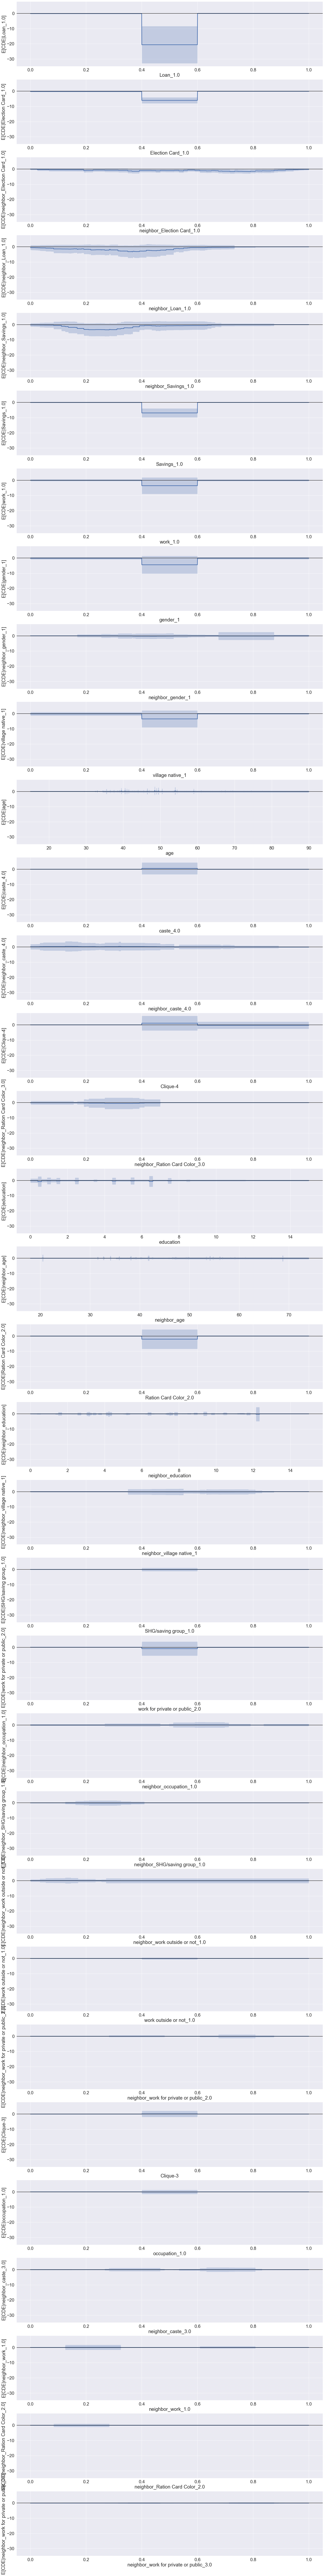

In [130]:
estimator_f,X = test_heterogeneity(outcome, treatment, df_unit, df_social_net, hypothesis, repeat = 100, sample_size=6000)

In [115]:
len(df_unit.columns)

63

100%|██████████| 33/33 [00:36<00:00,  1.10s/it]


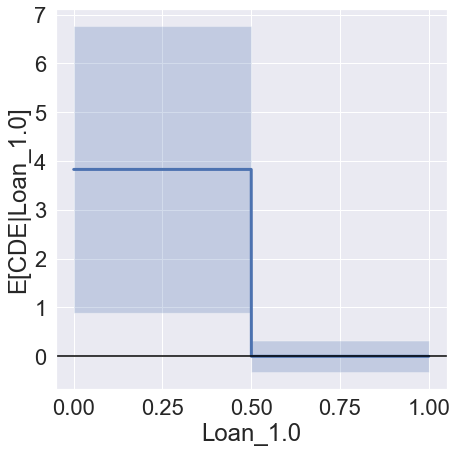

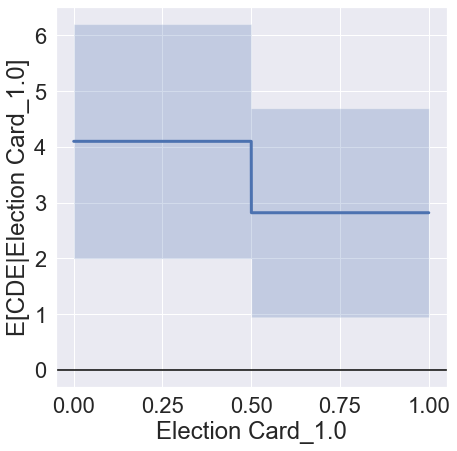

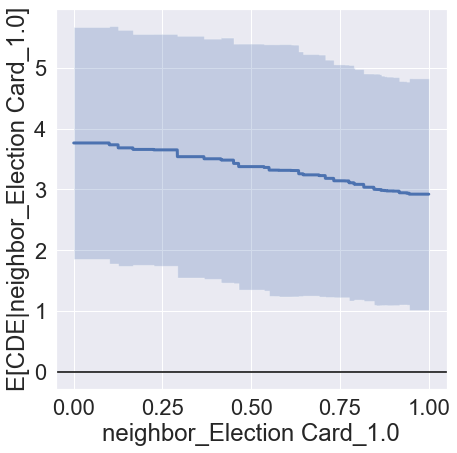

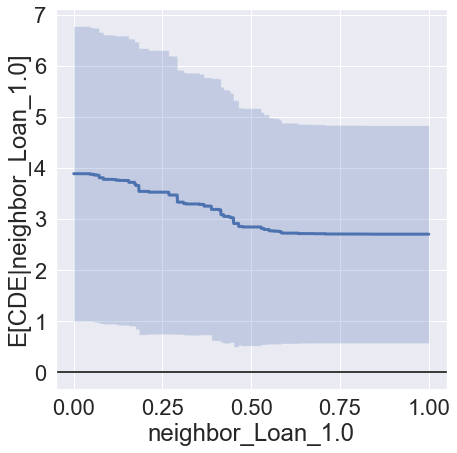

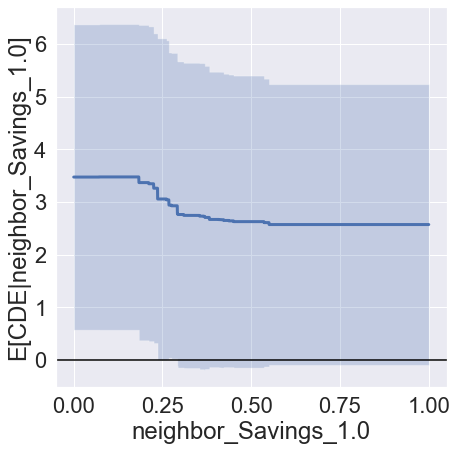

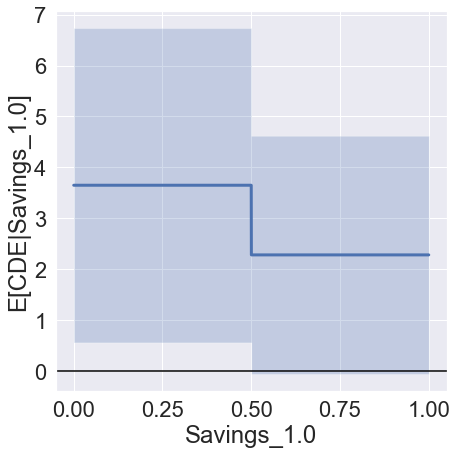

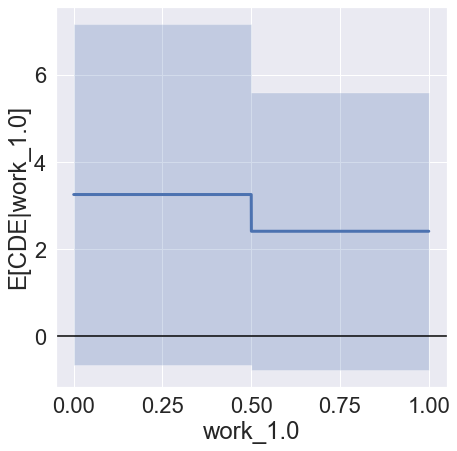

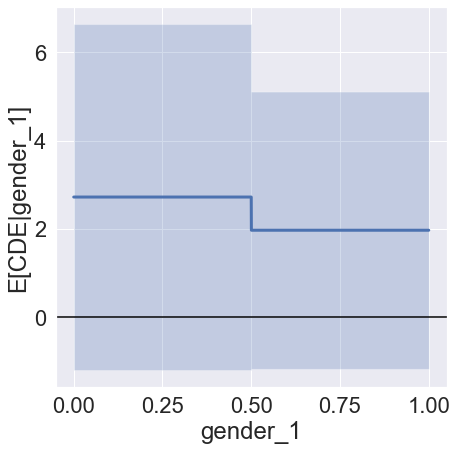

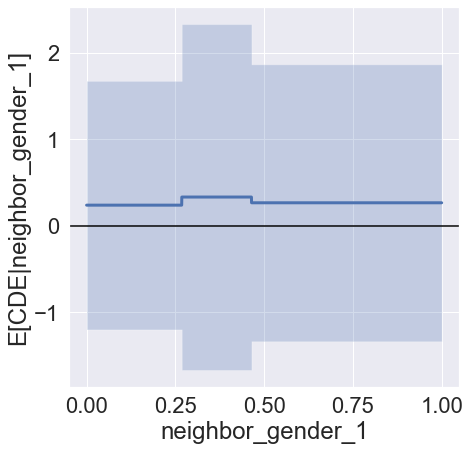

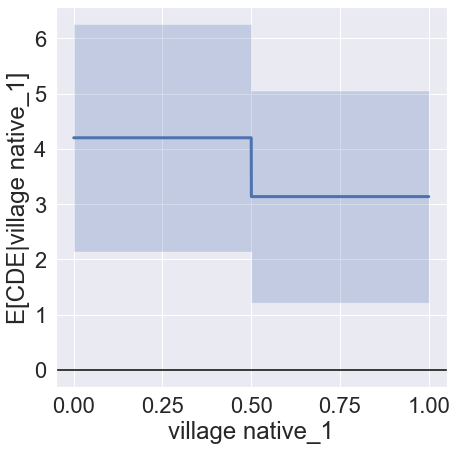

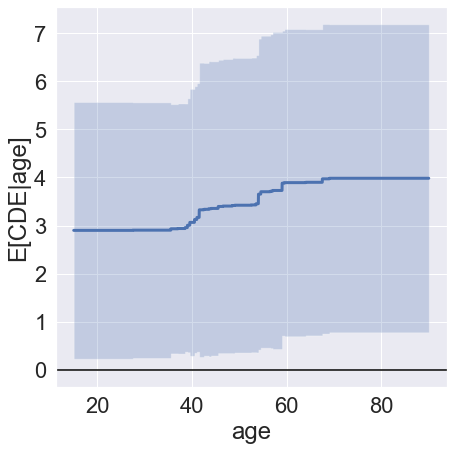

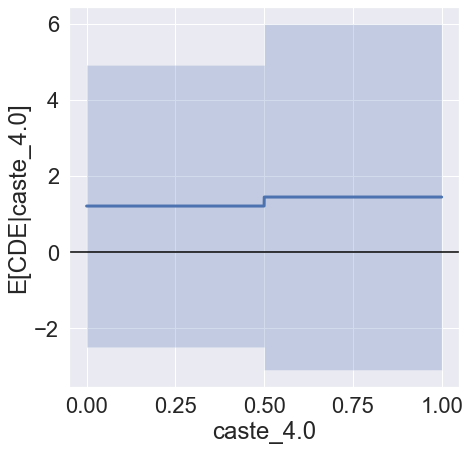

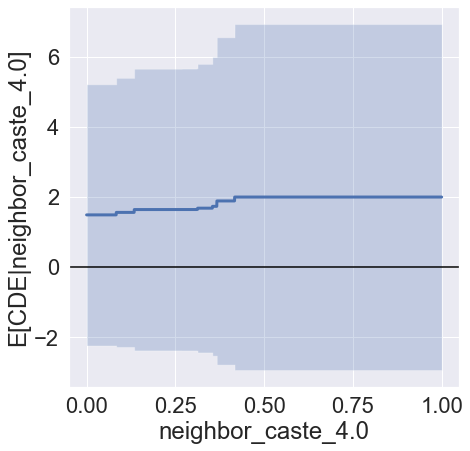

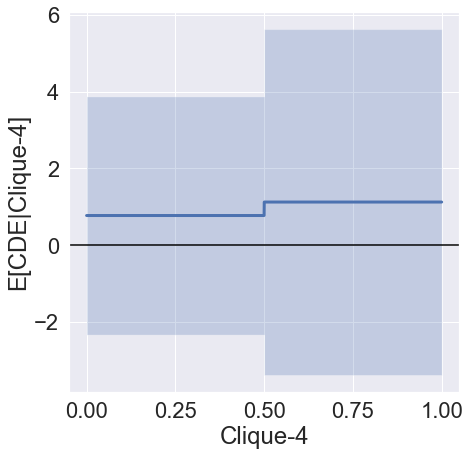

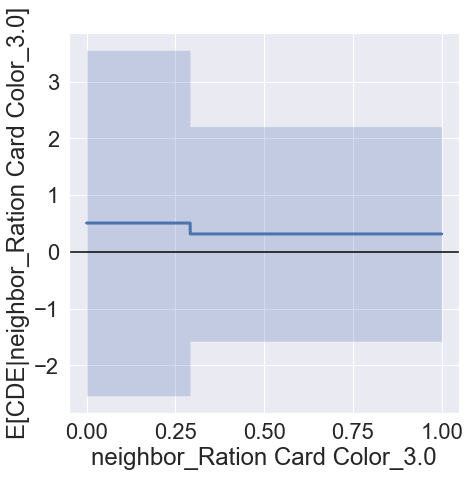

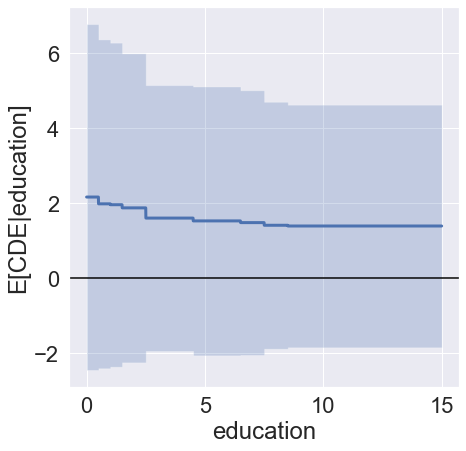

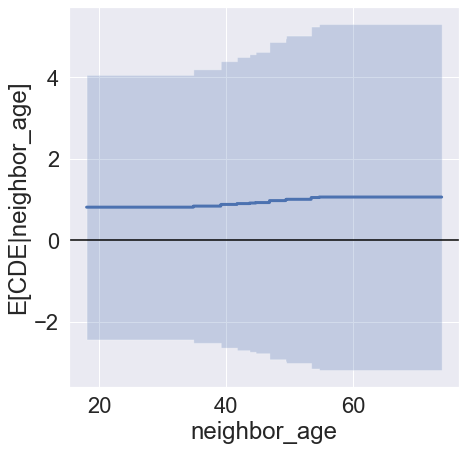

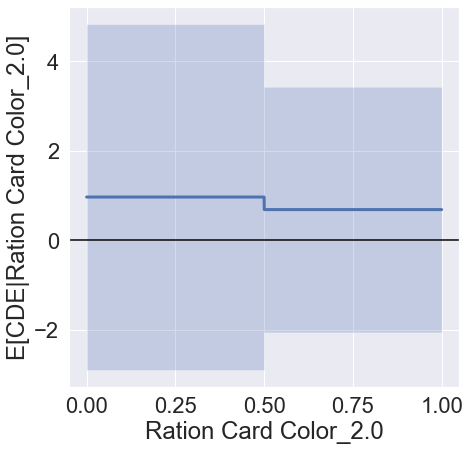

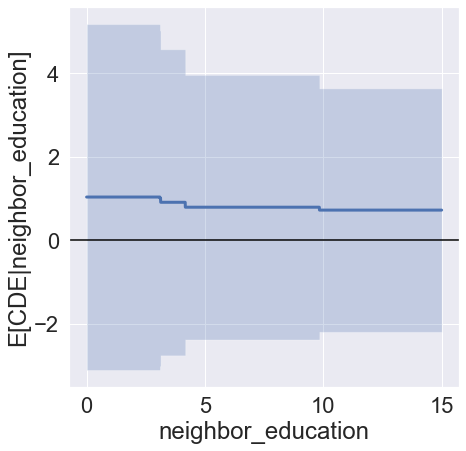

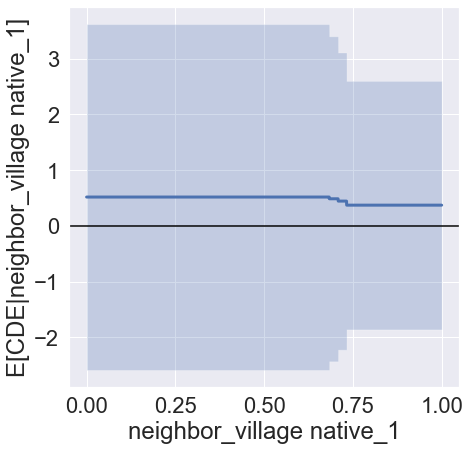

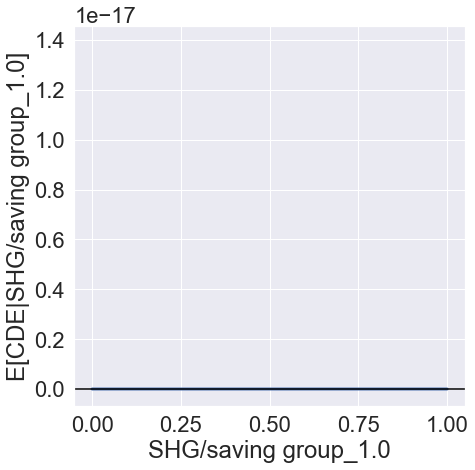

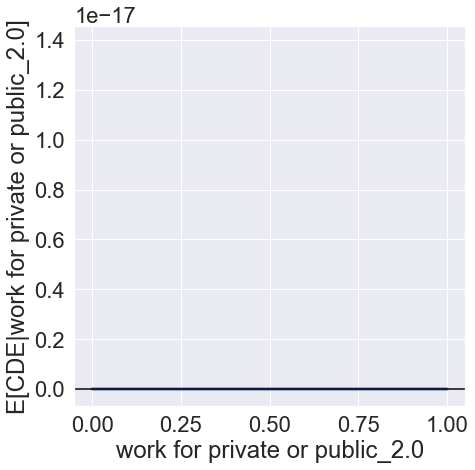

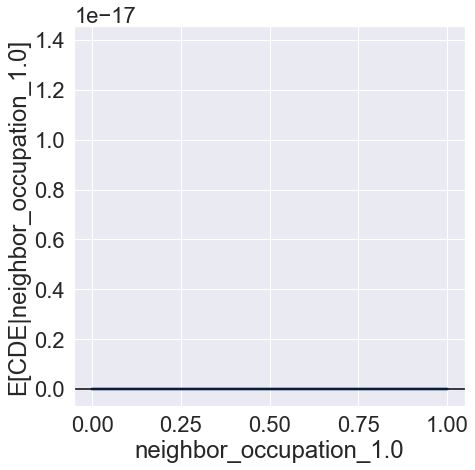

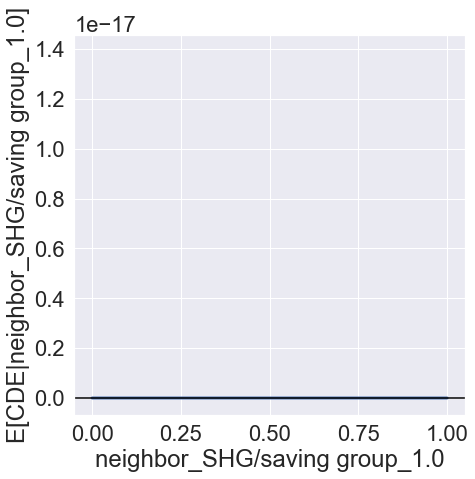

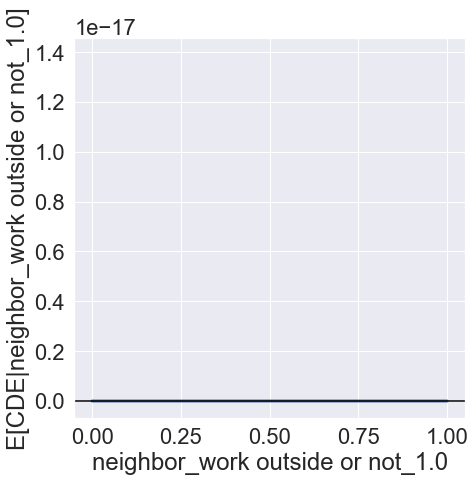

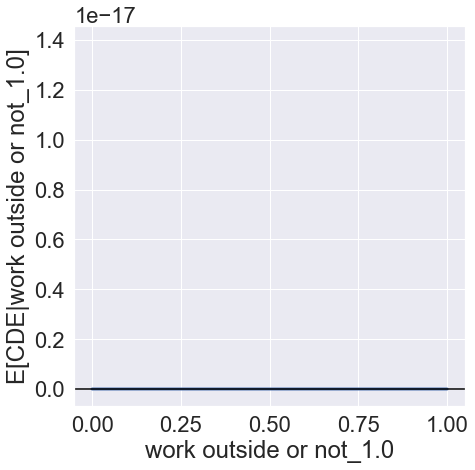

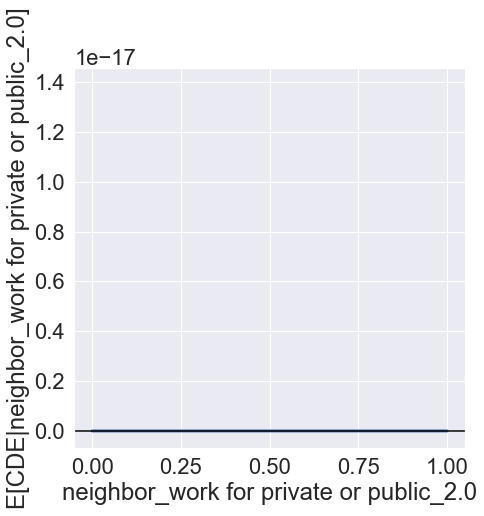

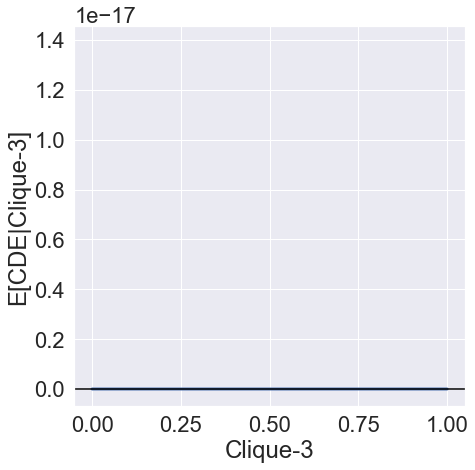

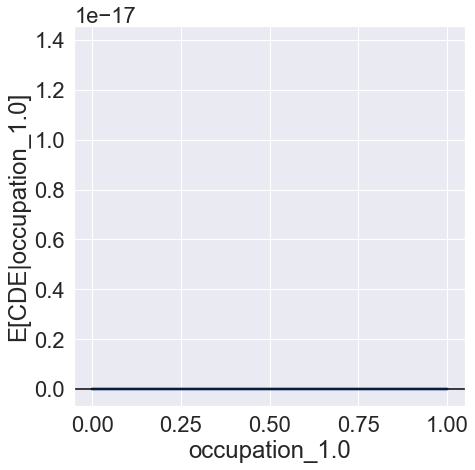

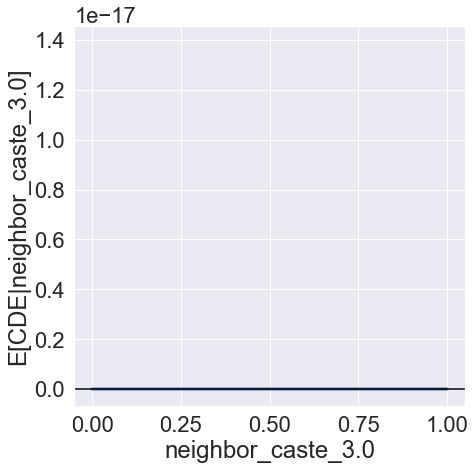

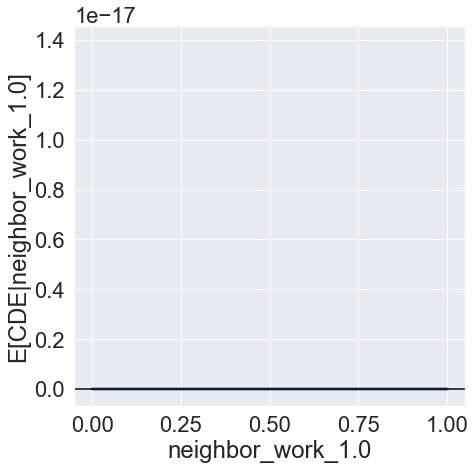

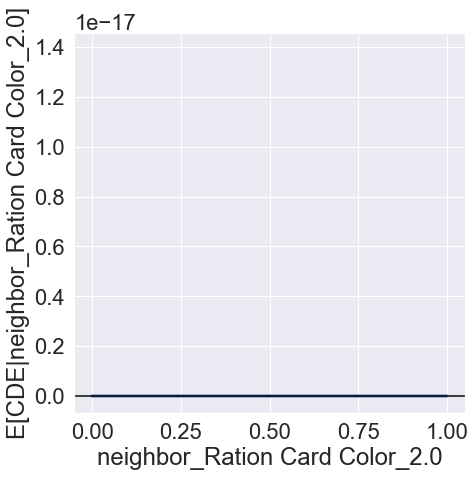

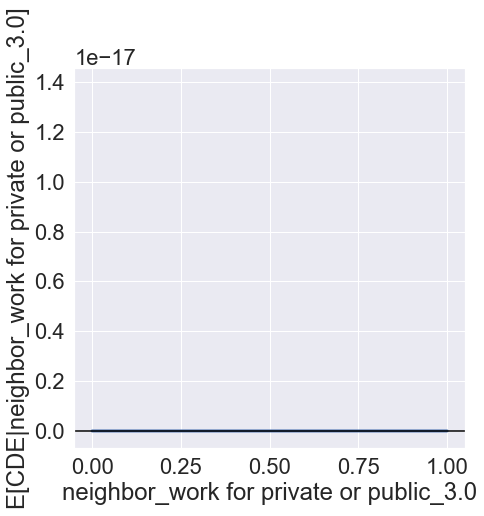

In [141]:
samples = 10000
cols = list(X.columns)
i = 0
# fig,ax = plt.subplots(ncols=1, nrows=( (len(estimator_f.keys())-1)//1) + 1, 
#                       figsize=(12,7*(( (len(estimator_f.keys())-1)//1) + 1)),
#                       sharex=False,sharey=True)
# plt.title('Marginal Distributions')
for key in tqdm(estimator_f.keys()):
    x_range = np.min(X[cols[key]]),np.max(X[cols[key]])
    X1 = np.zeros((samples,len(cols)))
    X1[:,key] = np.linspace(x_range[0],x_range[1],num=10000)
    est_k = estimator_f[key]
    y_hat_array = []
    for rep in range(10):
        y_hat = np.zeros((samples,))
        if rep in est_k.keys():
            for estr in est_k[rep]:
                y_hat += estr.predict(X1)#-estr.predict(X1-0.1))/0.2
            y_hat = y_hat/len(est_k[rep])
        y_hat_array.append(y_hat)
    y_hat_array = np.array(y_hat_array)
    fig = plt.figure(figsize=(7,7))
    plt.plot(X1[:,key],np.mean(y_hat_array,axis=0),linewidth=3)
    plt.axhline(0,c='black')
    plt.fill_between(X1[:,key], y1=np.mean(y_hat_array,axis=0)+2*np.std(y_hat_array,axis=0), 
                     y2=np.mean(y_hat_array,axis=0)-2*np.std(y_hat_array,axis=0),alpha=0.25)
    plt.xlabel(cols[key])
    plt.ylabel('E[CDE|%s]'%(cols[key]))
    i += 1
    fig.savefig('Figures/adaBoost_f_%s.png'%(cols[key].replace('/','_').replace('.',',')))

100%|██████████| 33/33 [00:17<00:00,  1.94it/s]


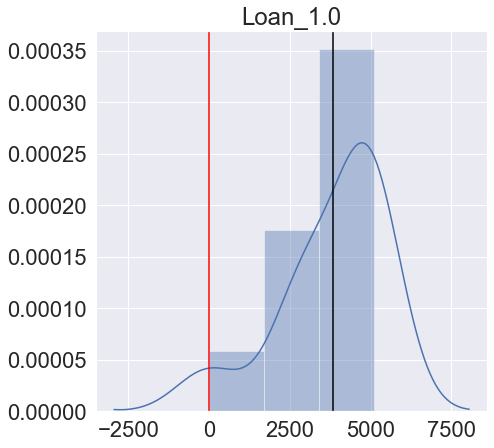

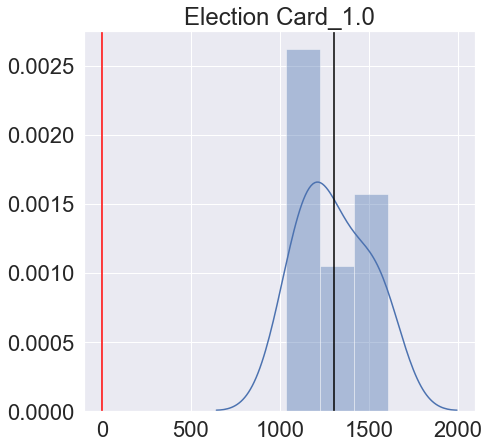

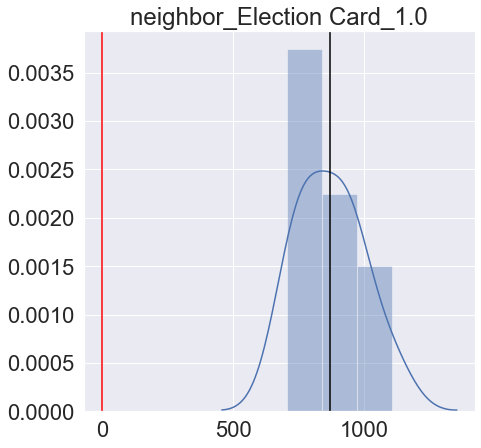

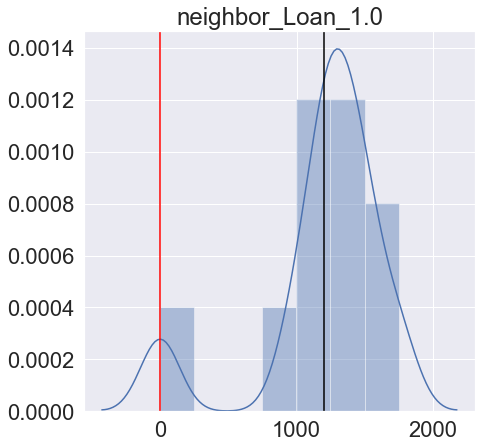

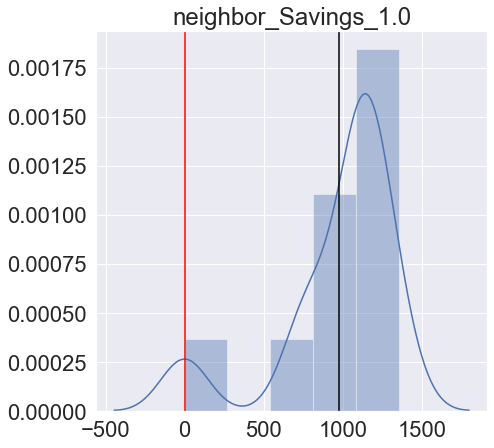

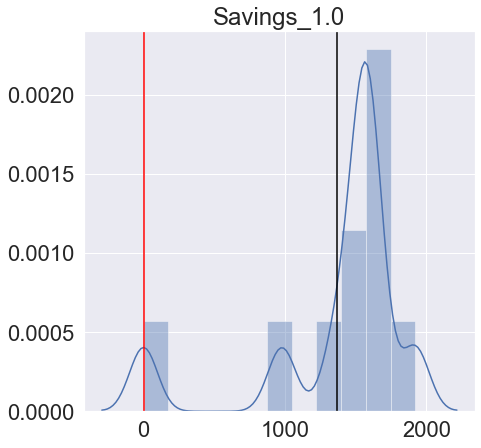

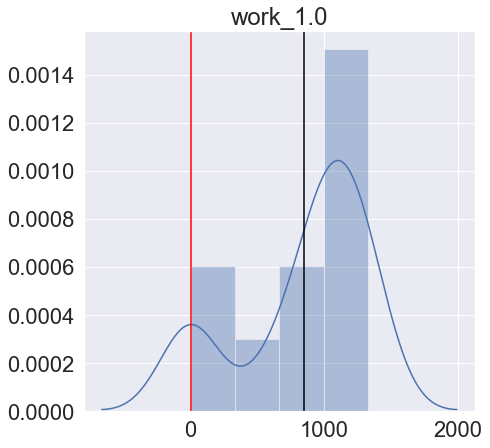

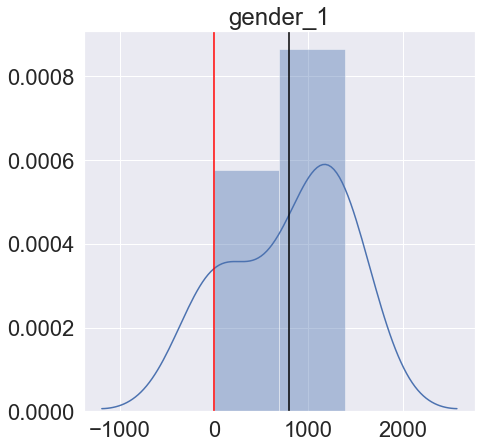

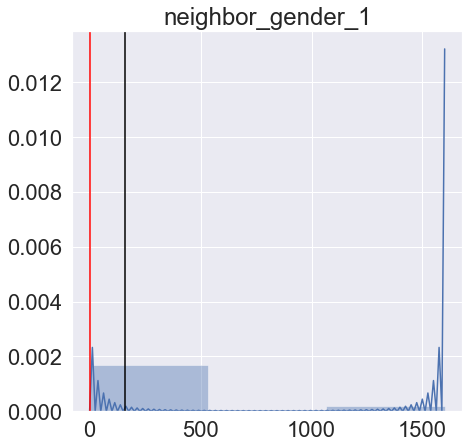

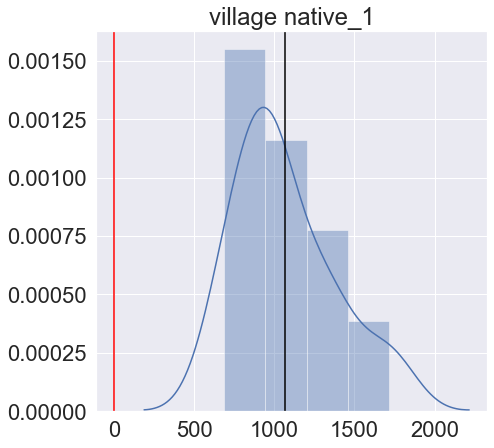

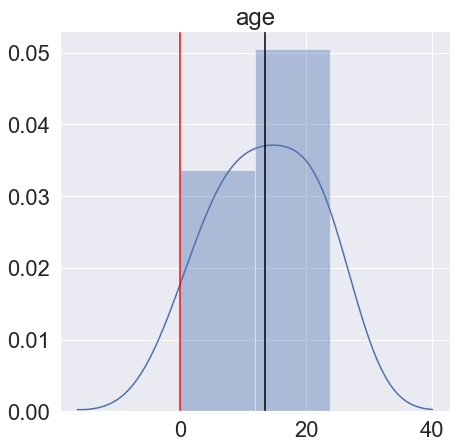

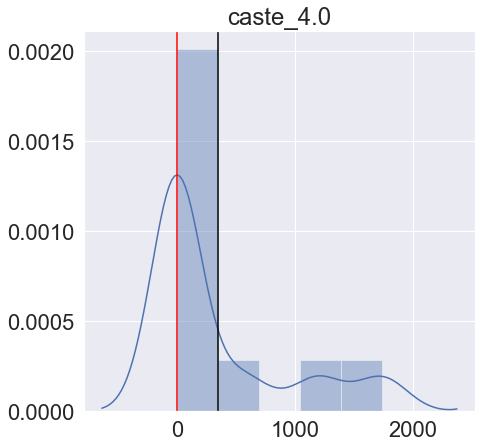

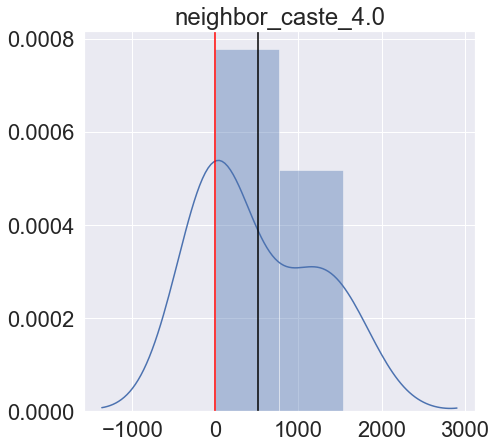

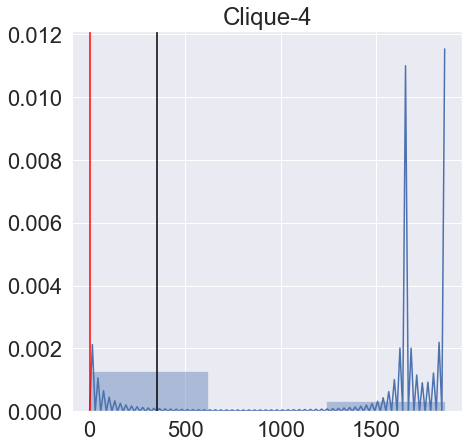

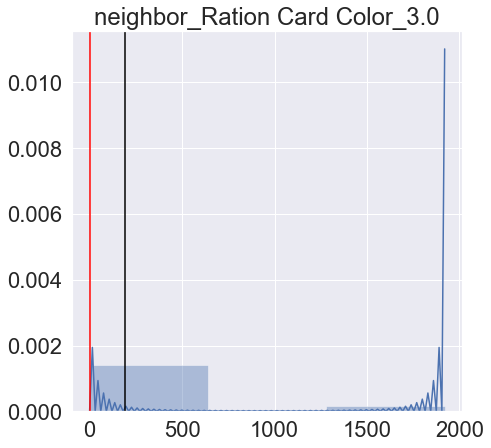

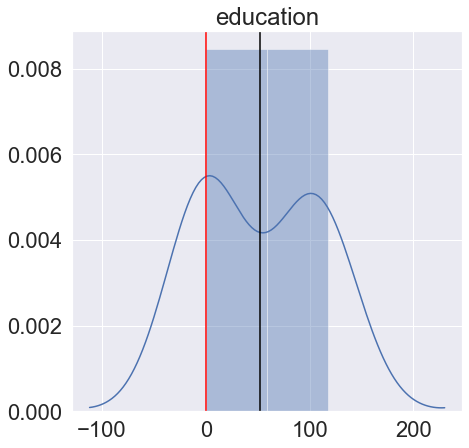

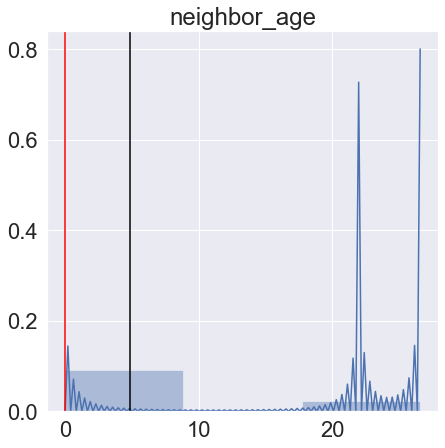

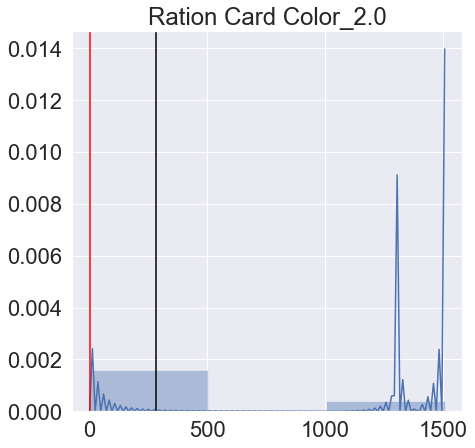

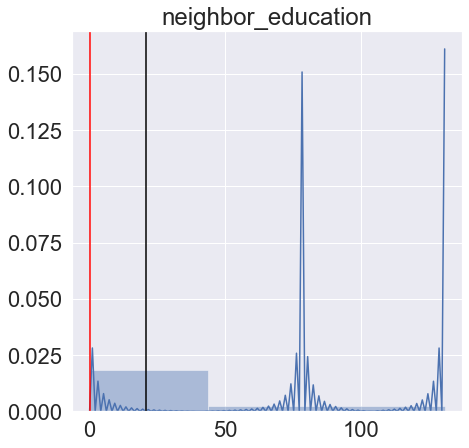

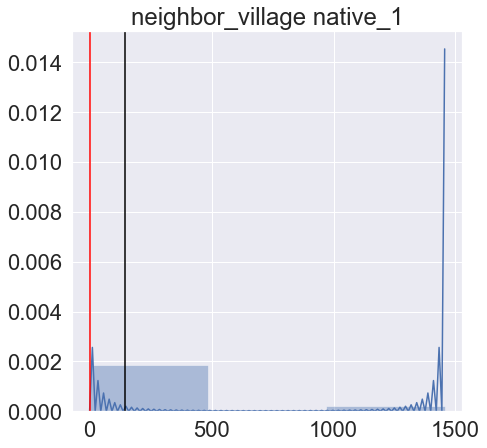

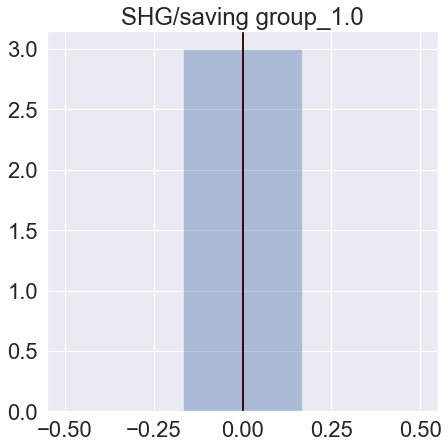

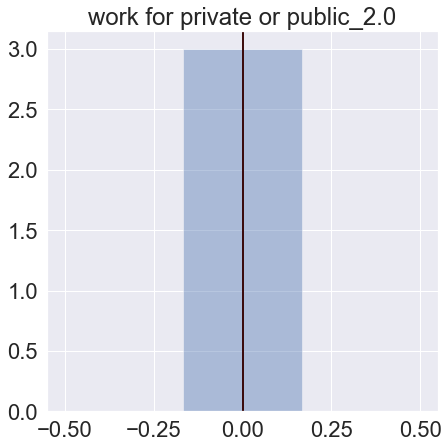

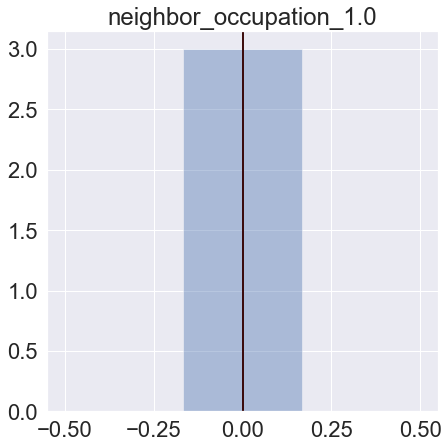

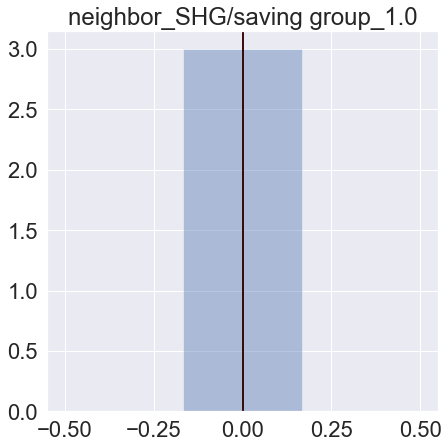

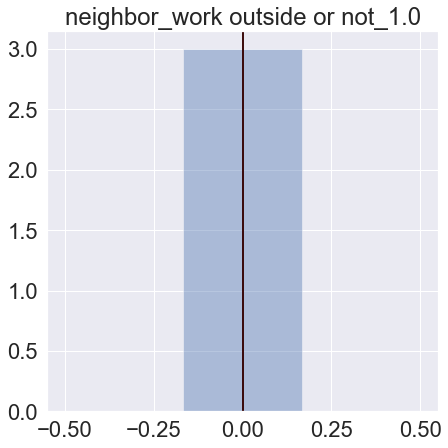

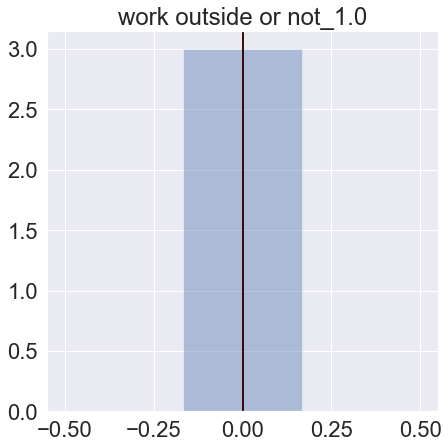

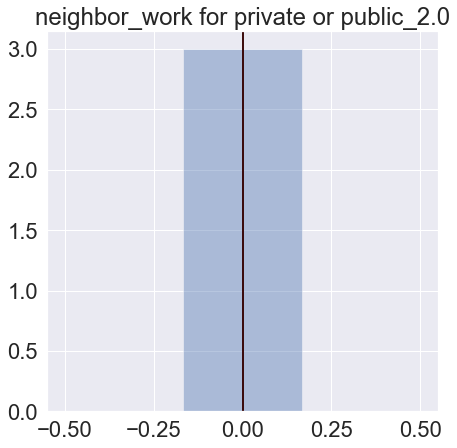

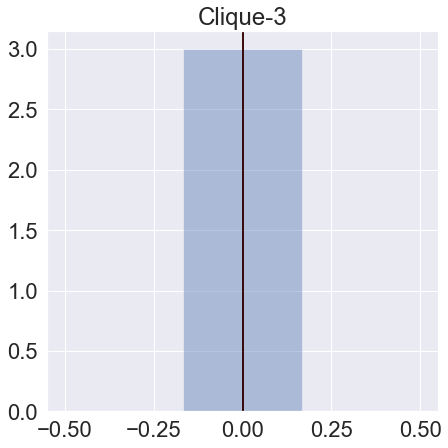

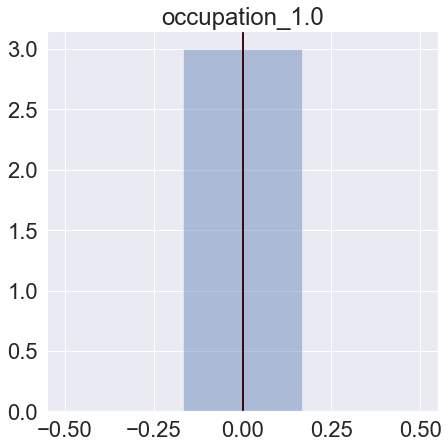

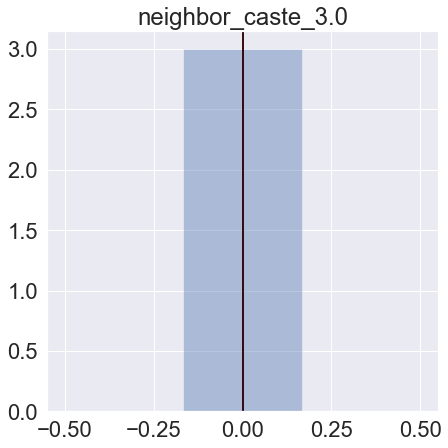

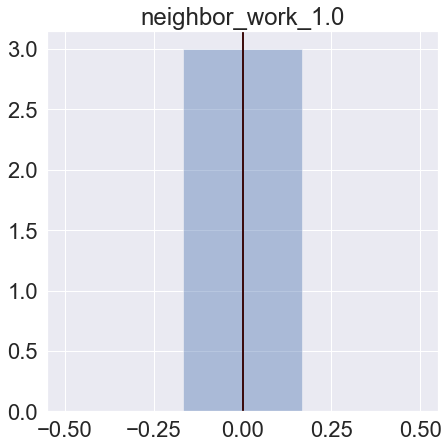

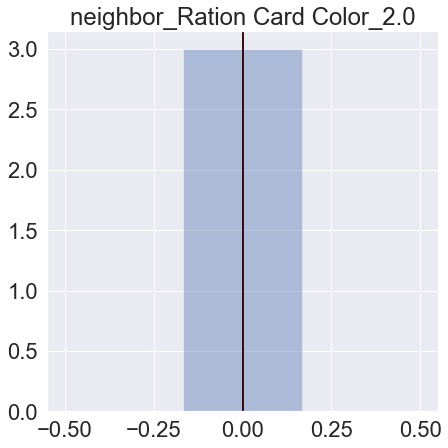

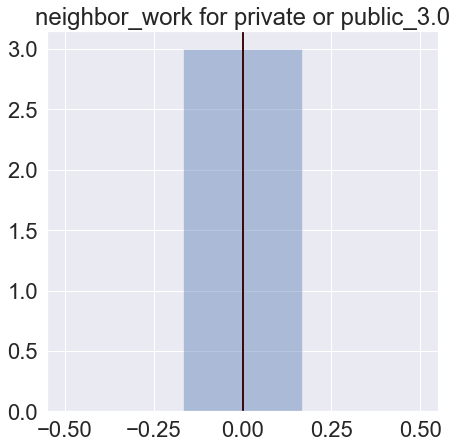

In [149]:
samples = 1000
cols = list(X.columns)
i = 0
# fig,ax = plt.subplots(ncols=1, nrows=( (len(estimator_f.keys())-1)//1) + 1, 
#                       figsize=(12,7*(( (len(estimator_f.keys())-1)//1) + 1)),
#                       sharex=False,sharey=True)
# plt.title('Marginal Distributions')
for key in tqdm(estimator_f.keys()):
    x_range = np.min(X[cols[key]]),np.max(X[cols[key]])
    X1 = np.zeros((samples,len(cols)))
    X1[:,key] = np.linspace(x_range[0],x_range[1],num=1000)
    est_k = estimator_f[key]
    y_hat_array = []
    for rep in range(10):
        y_hat = np.zeros((samples,))
        if rep in est_k.keys():
            for estr in est_k[rep]:
                y_hat += np.abs((estr.predict(X1)-estr.predict(X1-0.1))/0.1)
            y_hat = (y_hat/len(est_k[rep]))
        y_hat_array.append(np.sum(y_hat))
    y_hat_array = np.array(y_hat_array)
    fig = plt.figure(figsize=(7,7))
    sns.distplot(y_hat_array)
    plt.axvline(0,c='red')
    plt.axvline(np.mean(y_hat_array),c='black')
#     scipy.stats.gaussian_kde()
    plt.title(cols[key])
#     plt.plot(X1[:,key],np.mean(y_hat_array,axis=0),linewidth=3)
#     plt.axhline(0,c='black')
#     plt.fill_between(X1[:,key], y1=np.mean(y_hat_array,axis=0)+np.std(y_hat_array,axis=0), 
#                      y2=np.mean(y_hat_array,axis=0)-np.std(y_hat_array,axis=0),alpha=0.25)
#     plt.xlabel(cols[key])
#     plt.ylabel('$\Delta$E[CDE|%s]'%(cols[key]))
#     plt.tight_layout()
#     i += 1
    fig.savefig('Figures/adaBoost_df_%s.png'%(cols[key].replace('/','_').replace('.',',')))

In [152]:
import scipy.stats as stats

In [156]:
stats.gamma.pdf(0,10,scale=0.5)

0.0

In [174]:
print(survey_data[['occupation','Election Card','Savings','SHG/saving group','Loan']].dropna().sample(frac=1).head(10).astype(int).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  occupation &  Election Card &  Savings &  SHG/saving group &  Loan \\
id      &             &                &          &                   &       \\
\midrule
6214203 &           1 &              1 &        0 &                 0 &     0 \\
3916003 &           1 &              1 &        1 &                 0 &     1 \\
5000502 &           1 &              1 &        0 &                 0 &     0 \\
3108301 &          22 &              1 &        1 &                 0 &     1 \\
5920401 &           1 &              1 &        0 &                 0 &     1 \\
3903901 &          23 &              1 &        1 &                 0 &     0 \\
7217102 &          10 &              1 &        1 &                 1 &     1 \\
5011502 &           1 &              1 &        1 &                 1 &     1 \\
2814602 &           1 &              0 &        0 &                 0 &     0 \\
3205301 &           5 &              0 &        0 &                 0 & 